In [1]:
%cd /home/sasedov/StyleDomain/SimilarDomains

/home/sasedov/StyleDomain/SimilarDomains


In [2]:
device = 'cuda:0'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import clip 

import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

import io
from typing import Union, List, Dict
from contextlib import redirect_stdout

from core.utils.common import load_clip, mixing_noise
from core.utils.example_utils import (
    Inferencer, to_im, vstack_with_lines, hstack_with_lines, insert_image,
    project_e4e, project_restyle_psp, project_fse_without_image_generation, read_img
)
from core.utils.reading_weights import read_weights
from examples.draw_util import weights, set_seed, morph_g_ema, IdentityEditor, StyleEditor

/home/sasedov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
@torch.no_grad()
def encode_image(clip_model: nn.Module, preprocess, imgs: torch.Tensor):
    images = preprocess(imgs).to(device)
    image_features = clip_model.encode_image(images).detach()
    image_features /= image_features.clone().norm(dim=-1, keepdim=True)

    return image_features

@torch.no_grad()
def encode_text(clip_model: nn.Module, text: str, templates: List[str] = ("A {}",)):
    tokens = clip.tokenize(t.format(text) for t in templates).to(device)
    text_features = clip_model.encode_text(tokens).detach()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

@torch.no_grad()
def generate_clip_data(
    clip_model,
    preprocess,
    generator,
    model_da,
    config,
    latents=None,
    input_is_latent=False,
    offset_power=1.,
    fse_features_tensor=None,
    idx_k=5,
    shift_with_generator_feature_map=False,
    feature_scale=1.0,
    feature_shift_delta=None
):
    answer = []
    
    data_size, batch_size = config["evaluation"]["data_size"], config["evaluation"]["batch_size"]
    f_stdout = io.StringIO()

    for idx in tqdm(range(data_size // batch_size), miniters=16):
        if latents is None:
            with redirect_stdout(f_stdout):
                sample_z = mixing_noise(batch_size, generator.style_dim, config["mixing_noise"], device)
                imgs, _ = generator(
                    sample_z,
                    offsets=model_da(),
                    input_is_latent=False,
                    offset_power=offset_power
                )
        else:
            imgs = []
            for latents_idx in range(batch_size * idx, batch_size * (idx + 1)):
                if fse_features_tensor is not None:
                    features_in = fse_features_tensor[latents_idx].unsqueeze(0)
                    features_in = [None] * idx_k + [features_in] + [None] * (17 - idx_k)
                else:
                    features_in = None
                
                img, _ = generator(
                    latents[latents_idx].unsqueeze(0),
                    offsets=model_da(),
                    input_is_latent=input_is_latent,
                    offset_power=offset_power,
                    features_in=features_in,
                    shift_with_generator_feature_map=shift_with_generator_feature_map,
                    feature_scale=feature_scale,
                    feature_shift_delta=feature_shift_delta
                )
                imgs.append(img)
            imgs = torch.cat(imgs, dim=0)

        image_features = encode_image(clip_model, preprocess, imgs).detach()
        answer.append(image_features)

    return torch.cat(answer, dim=0)

In [5]:
def get_tril_elements_mask(linear_size):
    mask = np.zeros((linear_size, linear_size), dtype=bool)
    mask[np.tril_indices_from(mask)] = True
    np.fill_diagonal(mask, False)
    return mask

def mean_cosine_sim(imgs_encoded: torch.Tensor, mean_vector: torch.Tensor):
    return (imgs_encoded.unsqueeze(1) * mean_vector).sum(dim=-1).mean().item()

def std_cosine_sim(imgs_encoded: torch.Tensor, mean_vector: torch.Tensor):
    return nn.CosineSimilarity()(imgs_encoded, mean_vector).std().item()

def diversity_from_embeddings_pairwise_cosines(imgs_encoded: torch.Tensor):
    data = (imgs_encoded @ imgs_encoded.T).cpu().numpy()  # SURE ?
    mask = get_tril_elements_mask(data.shape[0])
    return np.mean(1 - data[mask])

In [6]:
@torch.no_grad()
def get_metrics(
    generator: nn.Module,
    model_da: nn.Module,
    config,
    target: Union[List[str], str, List[Image.Image], Image.Image],
    domain_descriptions: Union[List[str], str, None] = None,
    latents = None,
    input_is_latent = False,
    offset_power = 1.,
    fse_features_tensor = None,
    shift_with_generator_feature_map = False,
    feature_scale = 1.0,
    feature_shift_delta = None,
):
    metrics = {}
    model_da.eval()
    generator.eval()
    
    clip_models = {
        visual_encoder: load_clip(visual_encoder, device=device)
        for visual_encoder in config["evaluation"]["vision_models"]
    }
    
    transform = transforms.Compose(
        [
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]
    )
    
    if not isinstance(target, list):
        target = [target]
        
    if domain_descriptions is None:
        domain_descriptions = target
    elif not isinstance(domain_descriptions, list):
        domain_descriptions = [domain_descriptions]
    
    for key, (clip_model, preprocess) in clip_models.items():
        for target_class, domain_desc in zip(target, domain_descriptions):
            imgs_encoded = generate_clip_data(
                clip_model, preprocess, generator, model_da, config,
                latents=latents,
                input_is_latent=input_is_latent,
                offset_power=offset_power,
                fse_features_tensor=fse_features_tensor,
                shift_with_generator_feature_map=shift_with_generator_feature_map,
                feature_scale=feature_scale,
                feature_shift_delta=feature_shift_delta
            )
            
            if isinstance(target_class, str):
                domain_mean_vector = encode_text(clip_model, target_class)
            else:
                if not isinstance(target_class, torch.Tensor):
                    target_class = transform(target_class)
                domain_mean_vector = encode_image(clip_model, preprocess, target_class.unsqueeze(0))
            
            cls_description = "_".join(domain_desc.lower().split())

            key_quality = f"quality/{cls_description}/{key.replace('/', '-')}"
            key_diversity = f"diversity/{cls_description}/{key.replace('/', '-')}"

            metrics[key_quality] = mean_cosine_sim(imgs_encoded, domain_mean_vector)
            metrics[key_diversity] = diversity_from_embeddings_pairwise_cosines(imgs_encoded)

    return metrics

In [21]:
import json
import dlib
import numpy as np
import os
import PIL
import sys
import torch

from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset
from torchvision import transforms as transforms
from tqdm import tqdm

from core.utils.common import align_face
from core.utils.example_utils import (
    read_img, to_im, Inferencer,
    project_e4e, project_fse_without_image_generation
)
from core.utils.reading_weights import read_weights
from examples.draw_util import weights


# Like FeatureShiftDataset, but supports other encoder types
class MetricsImageDataset(Dataset):
    def __init__(self, dataset_config, latents_type="e4e", *args, **kwargs):
        super().__init__()

        self.config = dataset_config
        self.device = self.config.device
        self.image_size = self.config.image_size
        self.align_input = self.config.align_input

        self.dataset_path = Path(self.config.dataset_path)
        self.processed_path = Path(self.config.processed_path)
        self.processed_path.mkdir(exist_ok=True, parents=True)
        self.index_path = self.processed_path / "index.json"

        self.process_data = self.config.process_data
        if self.process_data:
            assert not os.listdir(self.processed_path), \
                "Required data processing, but the specified direcotry is not empty"

        self.dataset_size_limit = self.config.get('dataset_size_limit', int(1e10))
        self.default_image_transform = transforms.Compose(
            [
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ]
        )

        self.latents_type = latents_type

        self.index = self._get_or_load_index()

    def _get_or_load_index(self):
        if self.index_path.exists():
            with self.index_path.open() as f:
                index = json.load(f)
            if len(index) == self.dataset_size_limit:
                return index

        if self.process_data:
            assert False, "This dataset can not process data, use FeatureShiftDataset instead!"
        
        index = []
        for image_dir_path in self.processed_path.iterdir():
            if os.path.isdir(image_dir_path):
                index.append(os.path.basename(os.path.normpath(image_dir_path)))
                if len(index) == self.dataset_size_limit:
                    break
        
        with self.index_path.open('w') as f:
            json.dump(index, f)
        
        return index

    def __len__(self):
        return len(self.index)
    
    def _getitem__(self, ind):
        pass
    
    def collate_fn(self, batch_items):
        pass

    
    
class FeatureShiftMetricsImageDataset(MetricsImageDataset):
    def __init__(self, dataset_config, latents_type="fse", *args, **kwargs):
        super().__init__(dataset_config, latents_type, *args, **kwargs)
        
    def __getitem__(self, ind):
        image_dir_path = self.processed_path / self.index[ind]
        filename = os.path.basename(os.path.normpath(image_dir_path))

        image_path = list(image_dir_path.glob("image.*"))[0]
        e4e_inversion_path = list(image_dir_path.glob("e4e_inversion.*"))[0]
        fse_inversion_path = list(image_dir_path.glob("fse_inversion.*"))[0]

        image = self.default_image_transform(Image.open(image_path))
        e4e_inversion = self.default_image_transform(Image.open(e4e_inversion_path))
        fse_inversion = self.default_image_transform(Image.open(fse_inversion_path))

        e4e_latents = torch.load(image_dir_path / f"e4e_latents.pt", map_location="cpu")
        fse_latents = torch.load(image_dir_path / f"fse_latents.pt", map_location="cpu")

        e4e_features = torch.load(image_dir_path / f"e4e_features.pt", map_location="cpu")
        fse_features = torch.load(image_dir_path / f"fse_features.pt", map_location="cpu")

        if self.latents_type == "fse":
            fse_generator_features = torch.load(image_dir_path / f"fse_generator_features.pt", map_location="cpu")
        else:
            fse_generator_features = None

        fse_latents_on_inv = torch.load(image_dir_path / f"fse_latents_on_{self.latents_type}_inv.pt", map_location="cpu")
        fse_features_on_inv = torch.load(image_dir_path / f"fse_features_on_{self.latents_type}_inv.pt", map_location="cpu")

        return {
            "filename": filename,
            "image": image,
            "e4e_inversion": e4e_inversion,
            "e4e_latents": e4e_latents,
            "e4e_features": e4e_features,
            "fse_inversion": fse_inversion,
            "fse_latents": fse_latents,
            "fse_features": fse_features,
            "fse_generator_features": fse_generator_features,
            "fse_latents_on_inv": fse_latents_on_inv,
            "fse_features_on_inv": fse_features_on_inv
        }
    
    def collate_fn(self, batch_items):
        if self.latents_type == "fse":
            batch = {
                "filenames": [item["filename"] for item in batch_items],
                "images": torch.cat([item["image"].unsqueeze(0) for item in batch_items]),
                "e4e_inversion": torch.cat([item["fse_inversion"].unsqueeze(0) for item in batch_items]),
                "e4e_latents": torch.cat([item["fse_latents"].unsqueeze(0) for item in batch_items]),
                "fse_latents": torch.cat([item["fse_latents"].unsqueeze(0) for item in batch_items]),
                "fse_features": torch.cat([item["fse_features"] for item in batch_items]),
                "fse_latents_on_inv": torch.cat([item["fse_latents_on_inv"].unsqueeze(0) for item in batch_items]),
                "fse_features_on_inv": torch.cat([item["fse_features_on_inv"] for item in batch_items]),
                "e4e_features": torch.cat([item["fse_generator_features"].unsqueeze(0) for item in batch_items])
            }
            return batch
        batch = {
            "filenames": [item["filename"] for item in batch_items],
            "images": torch.cat([item["image"].unsqueeze(0) for item in batch_items]),
            "e4e_inversion": torch.cat([item["e4e_inversion"].unsqueeze(0) for item in batch_items]),
            "e4e_latents": torch.cat([item["e4e_latents"].unsqueeze(0) for item in batch_items]),
            "e4e_features": torch.cat([item["e4e_features"].unsqueeze(0) for item in batch_items]),
            "fse_inversion": torch.cat([item["fse_inversion"].unsqueeze(0) for item in batch_items]),
            "fse_latents": torch.cat([item["fse_latents"].unsqueeze(0) for item in batch_items]),
            "fse_features": torch.cat([item["fse_features"] for item in batch_items]),
            "fse_latents_on_inv": torch.cat([item["fse_latents_on_inv"].unsqueeze(0) for item in batch_items]),
            "fse_features_on_inv": torch.cat([item["fse_features_on_inv"] for item in batch_items])
        }
        return batch


class E4EMetricsImageDataset(MetricsImageDataset):
    def __init__(self, dataset_config, latents_type="e4e", *args, **kwargs):
        super().__init__(dataset_config, latents_type, *args, **kwargs)
        
    def __getitem__(self, ind):
        image_dir_path = self.processed_path / self.index[ind]
        filename = os.path.basename(os.path.normpath(image_dir_path))

        image_path = list(image_dir_path.glob("image.*"))[0]
        e4e_inversion_path = list(image_dir_path.glob("e4e_inversion.*"))[0]

        image = self.default_image_transform(Image.open(image_path))
        e4e_inversion = self.default_image_transform(Image.open(e4e_inversion_path))
        e4e_latents = torch.load(image_dir_path / f"e4e_latents.pt", map_location="cpu")

        return {
            "filename": filename,
            "image": image,
            "e4e_inversion": e4e_inversion,
            "e4e_latents": e4e_latents
        }
    
    def collate_fn(self, batch_items):
        batch = {
            "filenames": [item["filename"] for item in batch_items],
            "images": torch.cat([item["image"].unsqueeze(0) for item in batch_items]),
            "e4e_inversion": torch.cat([item["e4e_inversion"].unsqueeze(0) for item in batch_items]),
            "e4e_latents": torch.cat([item["e4e_latents"].unsqueeze(0) for item in batch_items])
        }
        return batch

    
class FSEMetricsImageDataset(MetricsImageDataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def __getitem__(self, ind):
        image_dir_path = self.processed_path / self.index[ind]
        filename = os.path.basename(os.path.normpath(image_dir_path))

        image_path = list(image_dir_path.glob("image.*"))[0]
        fse_inversion_path = list(image_dir_path.glob("fse_inversion.*"))[0]

        image = self.default_image_transform(Image.open(image_path))
        fse_inversion = self.default_image_transform(Image.open(fse_inversion_path))

        fse_latents = torch.load(image_dir_path / f"fse_latents.pt", map_location="cpu")
        fse_features = torch.load(image_dir_path / f"fse_features.pt", map_location="cpu")

        return {
            "filename": filename,
            "image": image,
            "fse_inversion": fse_inversion,
            "fse_latents": fse_latents,
            "fse_features": fse_features
        }
    
    def collate_fn(self, batch_items):
        batch = {
            "filenames": [item["filename"] for item in batch_items],
            "images": torch.cat([item["image"].unsqueeze(0) for item in batch_items]),
            "fse_inversion": torch.cat([item["fse_inversion"].unsqueeze(0) for item in batch_items]),
            "fse_latents": torch.cat([item["fse_latents"].unsqueeze(0) for item in batch_items]),
            "fse_features": torch.cat([item["fse_features"] for item in batch_items])
        }
        return batch


In [24]:
from pathlib import Path
from omegaconf import OmegaConf
from itertools import repeat
from torch.utils.data import DataLoader

from core.featureshift_trainer import get_image_domains, get_text_domains
from core.featureshift_dataset import FeatureShiftImageDataset
from core.parametrizations import BaseParametrization
from core.uda_models import uda_models
from core.utils.common import get_stylegan_conv_dimensions

import os
import sys


def inf_loop(dataloader):
    for loader in repeat(dataloader):
        yield from loader

        
class FeatureShiftDomainInferencer:
    def __init__(self, config, domains_info=None, enc_type="featureshift", offsets_coeffs=None):
        super().__init__()

        self.config = config
        self.device = config.training.device
        self.val_iters = config.evaluation.iters
        
        if domains_info is None:
            self.im_domains, self.domain_ims = get_image_domains()
            self.text_domains, self.domain_texts = get_text_domains()
            
            self.s_domains = self.im_domains + self.text_domains
            self.domain_ims_or_texts = self.domain_ims + self.domain_texts
        else:
            self.s_domains = domains_info["s_domains"]
            self.domain_ims_or_texts = domains_info["domain_ims_or_texts"]
            
        self.fse_idx_k = self.config.val_dataset.inversion.fse_idx_k
        self.latents_type = self.config.get("latents_type", "e4e")
        
        self.enc_type = enc_type
        assert enc_type in ["featureshift", "e4e", "fse", "fse_features", "fse_generator_shift"], \
            f'Incorrect encoder type {enc_type}, select from: ["featureshift", "e4e", "fse", "fse_features", "fse_generator_shift"]'

        self.source_generator = None
        self.models_da = None
        self.source_discriminator = None
        self.domain_discriminator = None
        self.trainable = None
        
        self.dataset = None
        self.dataloader = None

        self.normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        self.transform = transforms.Compose(
            [
                transforms.Resize((1024, 1024)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ]
        )

        self._setup_dataloaders()
        self._setup_source_generator()
        self._setup_models_da()
        self._setup_trainable()

        self.domain_offsets = {
            s_domain: self.models_da[s_domain]()
            for s_domain in self.s_domains
        }
        
        if offsets_coeffs is not None:
            for s_domain, offsets in self.domain_offsets.items():
                for coeff, conv_name in zip(offsets_coeffs[1:], offsets.keys()):
                    offsets[conv_name]['in'] = coeff * offsets[conv_name]['in']

        self.start_from_checkpoint()

    def _setup_dataloaders(self):
        if self.enc_type == "featureshift":
            self.dataset = FeatureShiftMetricsImageDataset(self.config.val_dataset, self.latents_type)
        elif self.enc_type == "e4e":
            self.dataset = E4EMetricsImageDataset(self.config.val_dataset, self.latents_type)
        else:
            self.dataset = FSEMetricsImageDataset(self.config.val_dataset, self.latents_type)
        
        self.dataloader = inf_loop(DataLoader(
            self.dataset,
            batch_size=self.config.val_dataset.batch_size,
            collate_fn=self.dataset.collate_fn,
            shuffle=self.config.val_dataset.get("shuffle", True),
            num_workers=self.config.val_dataset.get("num_workers", 1),
            drop_last=True
        ))

    def _setup_source_generator(self):
        self.source_generator = uda_models[self.config.training.source_generator](
            **self.config.training.source_generator_args #[self.config.training.source_generator]  # <-- use_feature_shift_conv = False
        )
        self.source_generator.patch_layers(self.config.training.patch_key)       # WTF ?
        self.source_generator.freeze_layers()
        self.source_generator.to(self.device)
    
    def _setup_models_da(self):
        self.models_da = {}
        for s_domain in self.s_domains:
            ckpt = read_weights(weights[s_domain])
            self.models_da[s_domain] = BaseParametrization(
                ckpt['patch_key'],
                get_stylegan_conv_dimensions(ckpt['sg2_params']['img_size']),
            )
            self.models_da[s_domain].load_state_dict(ckpt["state_dict"], strict=False)
            self.models_da[s_domain].to(self.device).eval()
            self.models_da[s_domain].freeze_layers()

    def _setup_trainable(self):
        self.trainable = uda_models[self.config.training.trainable](
            **self.config.training.trainable_generator_args #[self.config.training.trainable]  # <-- use_feature_shift_conv = True
        )
        self.trainable.patch_layers(self.config.training.patch_key)       # WTF ?
        trainable_layers = list(self.trainable.get_training_layers(
            phase=self.config.training.phase
        ))
        print('trainable_layers:', trainable_layers)
        self.trainable.freeze_layers()
        # self.trainable.unfreeze_layers(trainable_layers)
        self.trainable.to(self.device)
        self.trainable.eval()
                
    def start_from_checkpoint(self):
        step = 0
        if self.config.training.checkpointing.start_from:
            state_dict = torch.load(self.config.training.checkpointing.start_from, map_location='cpu')
            step = state_dict['step']
            self.trainable.load_state_dict(state_dict['trainable'])
            print('starting from step {}'.format(step))
        return step
    
    def _move_batch_to_device(self, batch):
        for k, v in batch.items():
            if k not in ["filenames"]:
                batch[k] = v.to(self.device)

    def forward_featureshift(self, batch, s_domain):
        batch["e4e_latents"] = batch["e4e_latents"].unsqueeze(0)
        batch["fse_latents"] = batch["fse_latents"].unsqueeze(0)
        batch["fse_latents_on_inv"] = batch["fse_latents_on_inv"].unsqueeze(0)
        # FOR LATENTS_TYPE == "FSE" TENSORS SHOULD BE ALREADY SWAPPED AS IN FEATURESHIFT DATASET
        # (SO FOR LATENTS_TYPE == "FSE" BATCH["E4E_LATENTS"] ARE ACTUALLY FSE ONES)

        with torch.no_grad():
            batch["e4e_domain_inversion"], batch["e4e_domain_features"] = self.source_generator(
                styles=batch["e4e_latents"],
                offsets=self.domain_offsets[s_domain],
                input_is_latent=True,
                features_in=None,
                shift_with_generator_feature_map=False,
                return_latents=False,
                return_features=True
            )

        batch["e4e_domain_features"] = [x.unsqueeze(0) for x in batch["e4e_domain_features"][self.fse_idx_k]]
        batch["e4e_domain_features"] = torch.cat(batch["e4e_domain_features"])
        batch["e4e_features_delta"] = batch["e4e_domain_features"] - batch["e4e_features"]
        
        batch["feature_shift_domain_inversion_fse"], _ = self.trainable(
            styles=batch["fse_latents"],
            offsets=self.domain_offsets[s_domain],
            input_is_latent=True,
            features_in=batch["fse_features"],
            shift_with_generator_feature_map=False,
            feature_shift_delta=batch["e4e_features_delta"]
        )
    
    def forward_latents_only(self, batch, s_domain, enc_type="e4e"):
        if enc_type == "e4e":
            batch["e4e_latents"] = batch["e4e_latents"].unsqueeze(0)
        else:
            batch["fse_latents"] = batch["fse_latents"].unsqueeze(0)
        
        with torch.no_grad():
            batch[f"{enc_type}_domain_inversion"], _ = self.source_generator(
                styles=batch[f"{enc_type}_latents"],
                offsets=self.domain_offsets[s_domain],
                input_is_latent=True,
                features_in=None,
                shift_with_generator_feature_map=False,
                return_latents=False,
                return_features=False
            )
    
    def forward_fse_features(self, batch, s_domain, shift_with_generator_feature_map=False):
        batch["fse_latents"] = batch["fse_latents"].unsqueeze(0)
        
        with torch.no_grad():
            if not shift_with_generator_feature_map:
                name = "fse_features_domain_inversion"
            else:
                name = "fse_generator_shift_domain_inversion"
            
            batch[name], _ = self.source_generator(
                styles=batch[f"fse_latents"],
                offsets=self.domain_offsets[s_domain],
                input_is_latent=True,
                features_in=batch["fse_features"],
                shift_with_generator_feature_map=shift_with_generator_feature_map,
                return_latents=False,
                return_features=False
            )

    def forward(self, batch, s_domain, enc_type="featureshift"):
        self._move_batch_to_device(batch)
        
        if enc_type == "featureshift":
            self.forward_featureshift(batch, s_domain)
        elif enc_type == "e4e" or enc_type == "fse":
            self.forward_latents_only(batch, s_domain, enc_type)
        elif enc_type == "fse_features":
            self.forward_fse_features(batch, s_domain, False)
        elif enc_type == "fse_generator_shift":
            self.forward_fse_features(batch, s_domain, True)
        else:
            assert False, f'Incorrect encoder type {enc_type}, select from: ["featureshift", "e4e", "fse", "fse_features", "fse_generator_shift"]'
        
    @torch.no_grad()
    def generate_clip_data(self, clip_model, preprocess, s_domain):       
        answer = []
        for i, batch in tqdm(enumerate(self.dataloader), desc='train', total=self.val_iters):
            self.forward(batch, s_domain, enc_type=self.enc_type)
            
            if self.enc_type == "featureshift":
                imgs = batch["feature_shift_domain_inversion_fse"]
            else:
                imgs = batch[f"{self.enc_type}_domain_inversion"]
            
            image_features = encode_image(clip_model, preprocess, imgs).detach()
            answer.append(image_features)
            
            if i + 1 == self.val_iters:
                break

        return torch.cat(answer, dim=0)
    
    @torch.no_grad()
    def get_metrics(self, save_path=None):
        metrics = {}

        clip_models = {
            visual_encoder: load_clip(visual_encoder, device=self.device)
            for visual_encoder in config.evaluation.vision_models
        }

        transform = transforms.Compose(
            [
                transforms.Resize((1024, 1024)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ]
        )

        for key, (clip_model, preprocess) in clip_models.items():
            for s_domain, domain_target in zip(self.s_domains, self.domain_ims_or_texts):
                
                imgs_encoded = self.generate_clip_data(clip_model, preprocess, s_domain)

                if isinstance(domain_target, str):
                    domain_mean_vector = encode_text(clip_model, domain_target)
                    domain_desc = domain_target
                else:
                    if not isinstance(domain_target, torch.Tensor):
                        domain_target = transform(domain_target)
                    domain_mean_vector = encode_image(
                        clip_model, preprocess, domain_target.unsqueeze(0)
                    )
                    domain_desc = s_domain

                cls_description = "_".join(domain_desc.lower().split())

                key_quality = f"quality/{cls_description}/{key.replace('/', '-')}"
                key_diversity = f"diversity/{cls_description}/{key.replace('/', '-')}"

                metrics[s_domain] = {self.enc_type: {}}
                metrics[s_domain][self.enc_type][key_quality] = mean_cosine_sim(imgs_encoded, domain_mean_vector)
                metrics[s_domain][self.enc_type][key_diversity] = diversity_from_embeddings_pairwise_cosines(imgs_encoded)

        if save_path is not None:
            self.save_metrics(metrics, save_path)
        return metrics
    
    def save_metrics(
        self,
        metrics,
        save_path="/home/sasedov/StyleDomain/SimilarDomains/domain_encoder_metrics/feature_shift_domain_encoder_metrics.txt"
    ):
        if os.path.exists(save_path):
            print("Save path already exists!", file=sys.stderr)
            save_path += "_1"
            while os.exists(save_path):
                save_path[-1] = chr(ord(save_path[-1]) + 1)
            
            print(f"Changed to {save_path}!")
            
        with open(save_path, "w") as f:
            for s_domain, stats in metrics.items():
                f.write(f'{s_domain}\n')
                for enc_name, enc_stats in stats.items():
                    f.write(f'{enc_name}\n')
                    for stat_name, enc_stat in enc_stats.items():
                        f.write(f'{stat_name}, {enc_stat}\n')
                    f.write('\n')
                f.write('____\n')

In [17]:
# FEATURESHIFT
from pathlib import Path
from omegaconf import OmegaConf
import yaml

def get_image_domains():
    f_stdout = io.StringIO()

    domain_images_path = 'image_domains/'
    domain_images = {}

    for domain_image_filename in tqdm(os.listdir(domain_images_path)):
        if '.' not in domain_image_filename:
            continue
        s_domain, file_ext = domain_image_filename.split('.')
        if file_ext in ['png', 'jpg'] and s_domain != 'anime' and s_domain in weights:
            with redirect_stdout(f_stdout):
                domain_images[s_domain] = read_img(domain_images_path + domain_image_filename, align_input=False)

    domain_images = domain_images.items()
    s_domains = [x[0] for x in domain_images]
    domain_ims = [x[1] for x in domain_images]

    ignored_image_domains = ['joker', 'sketch']
    for domain in ignored_image_domains:
        if domain in s_domains:
            ind = s_domains.index(domain)
            s_domains.pop(ind)
            domain_ims.pop(ind)

    print('Considering the following image domains:', *s_domains)
    return s_domains, domain_ims

def get_text_domains(domain_dir_path='pretrained/checkpoints_iccv'):
    path = Path(domain_dir_path)
    
    s_domains = []
    domain_texts = []
    
    for domain_dir in tqdm(path.iterdir()):
        with open(domain_dir / 'config.yaml', 'r') as file:
            domain_config = yaml.safe_load(file)
        
        if domain_config['training']['target_class'][-4:] not in ['.png', '.jpg']:
            s_domains.append(domain_dir.name[:-7])  # cut out _sdelta in the end
            domain_texts.append(domain_config['training']['target_class'])
            if 'indomain' in s_domains[-1]:
                domain_texts[-1] += ' (indomain)'

    print('Considering the following text domains:', *s_domains)
    return s_domains, domain_texts

config_path = Path("configs/featureshift_configs/val_config.yaml")
config = OmegaConf.load(config_path)

im_domains, domain_ims = get_image_domains()
text_domains, domain_texts = get_text_domains()


diff_im_domains = [
    "nigelwy_untitled_artwork_18",
    "speed_paint",
    "titan_erwin",
    "wesley_gardner_portraitstudy",
    "stanislav_galai_04_23",
    "mermaid",
    "rich_d_amaru_studyfinal",
    "jojo",
    "joker",
    "titan_armin"
]

diff_text_domains = [
    "tolkien_elf",
    "botero",
    "modigliani_painting",
    "hermione_granger_indomain",
    "hermione_granger",
    "dali_painting",
    "neanderthal",
    "werewolf",
    "modigliani_painting_indomain",
    "ukiyo-e"
]


diff_im_domains_ind = [i for i, domain in enumerate(im_domains) if domain in diff_im_domains]
im_domains = [im_domains[i] for i in diff_im_domains_ind]
domain_ims = [domain_ims[i] for i in diff_im_domains_ind]


diff_text_domains_ind = [i for i, domain in enumerate(text_domains) if domain in diff_text_domains]
text_domains = [text_domains[i] for i in diff_text_domains_ind]
domain_texts = [domain_texts[i] for i in diff_text_domains_ind]

domain_info = {}
domain_info["s_domains"] = im_domains + text_domains
domain_info["domain_ims_or_texts"] = domain_ims + domain_texts

100%|██████████| 37/37 [00:00<00:00, 2647.11it/s]


Considering the following image domains: jojo nigelwy_untitled_artwork_18 digital_painting_jing titan_armin oliver_wetter_corie_lynn_concept_1_final_back_web murasaki_nora_asuya disney_princess remi_castaneda_sean_connery_final stanislav_galai_04_23 anastasia maria_trepalina_img_6833_1 rain_artwork_dtiyschallennge mermaid truc_huynh_hex_009v2 speed_paint naufal_ilyasa_seraphine_ig_full_res rich_d_amaru_studyfinal ricardo_viana_render2 wesley_gardner_portraitstudy titan_erwin


76it [00:02, 26.85it/s]

Considering the following text domains: edvard_munch_painting the_thanos tolkien_elf_indomain neanderthal_indomain modigliani_painting sketch hulk minimalist_drawing zombie_indomain pop_art_indomain pixar hulk_indomain edvard_munch_painting_indomain frida_kahlo_painting hermione_granger claude_monet_painting dali_painting neanderthal ukiyo-e botero_indomain frida_kahlo_painting_indomain impressionist_drawing_indomain werewolf_indomain impressionism_painting_indomain dali_painting_indomain botero modigliani_painting_indomain constructivism_indomain impressionist_drawing constructivism minimalist_drawing_indomain joker pop_art anime_indomain anime tolkien_elf werewolf ukiyo-e_indomain zombie impressionism_painting disney_princess_indomain disney_princess hermione_granger_indomain cubism_painting_indomain sketch_indomain claude_monet_painting_indomain cubism_painting the_thanos_indomain pixar_indomain joker_indomain


In [18]:
print(domain_info["s_domains"])

['jojo', 'nigelwy_untitled_artwork_18', 'titan_armin', 'stanislav_galai_04_23', 'mermaid', 'speed_paint', 'rich_d_amaru_studyfinal', 'wesley_gardner_portraitstudy', 'titan_erwin', 'modigliani_painting', 'hermione_granger', 'dali_painting', 'neanderthal', 'ukiyo-e', 'botero', 'modigliani_painting_indomain', 'tolkien_elf', 'werewolf', 'hermione_granger_indomain']


In [93]:
inferencer = FeatureShiftDomainInferencer(config, domain_info)
metrics = inferencer.get_metrics(
    save_path="/home/sasedov/StyleDomain/SimilarDomains/domain_encoder_metrics/feature_shift_fse_latents_domain_encoder_metrics.txt"
)

torch.Size([4096, 512])
torch.Size([4096, 512])
trainable_layers: [FeatureiResnet(
  (res_blocks): ModuleDict(
    (res_block_1_1): IBasicBlock(
      (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1024)
      (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (res_block_1_2): IBasicBlock(
      (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.8798217773438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 519.6333618164062


train:   3%|▎         | 1/30 [00:06<03:02,  6.28s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.3849487304688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 519.7315673828125


train:   7%|▋         | 2/30 [00:10<02:20,  5.00s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.2372436523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.5291442871094


train:  10%|█         | 3/30 [00:14<02:03,  4.59s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.5733642578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.4393310546875


train:  13%|█▎        | 4/30 [00:18<01:54,  4.40s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.1483764648438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.4971923828125


train:  17%|█▋        | 5/30 [00:22<01:47,  4.30s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.945556640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.8631591796875


train:  20%|██        | 6/30 [00:26<01:41,  4.21s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.9899291992188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.4022827148438


train:  23%|██▎       | 7/30 [00:30<01:36,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.2244262695312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.2737426757812


train:  27%|██▋       | 8/30 [00:34<01:31,  4.16s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.7325439453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.67218017578125


train:  30%|███       | 9/30 [00:39<01:26,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.6199951171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.9801635742188


train:  33%|███▎      | 10/30 [00:43<01:22,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.3357543945312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.7010498046875


train:  37%|███▋      | 11/30 [00:47<01:17,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.8110961914062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.9597778320312


train:  40%|████      | 12/30 [00:51<01:13,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.7356567382812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.3703002929688


train:  43%|████▎     | 13/30 [00:55<01:09,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.0408325195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 504.6215515136719


train:  47%|████▋     | 14/30 [00:59<01:05,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.4619140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 518.5154418945312


train:  50%|█████     | 15/30 [01:03<01:01,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.3052368164062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 528.49609375


train:  53%|█████▎    | 16/30 [01:07<00:57,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.9865112304688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 504.55352783203125


train:  57%|█████▋    | 17/30 [01:11<00:53,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.6799926757812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.9102172851562


train:  60%|██████    | 18/30 [01:15<00:48,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.1505126953125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.91668701171875


train:  63%|██████▎   | 19/30 [01:19<00:44,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.951904296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.5584716796875


train:  67%|██████▋   | 20/30 [01:23<00:40,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.9314575195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 517.619140625


train:  70%|███████   | 21/30 [01:28<00:36,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.2518920898438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.9144287109375


train:  73%|███████▎  | 22/30 [01:32<00:32,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 660.9488525390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 529.4617309570312


train:  77%|███████▋  | 23/30 [01:36<00:28,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.1038818359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 524.3674926757812


train:  80%|████████  | 24/30 [01:40<00:24,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.275634765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.7578125


train:  83%|████████▎ | 25/30 [01:44<00:20,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.0032348632812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.818603515625


train:  87%|████████▋ | 26/30 [01:48<00:16,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.1142578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.3360595703125


train:  90%|█████████ | 27/30 [01:52<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.42236328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 518.1202392578125


train:  93%|█████████▎| 28/30 [01:56<00:08,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 666.8375244140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 536.739990234375


train:  97%|█████████▋| 29/30 [02:00<00:04,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 660.5794067382812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 532.0888061523438


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.6198120117188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.0352172851562


train:   3%|▎         | 1/30 [00:04<01:56,  4.01s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.3421020507812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 514.9207763671875


train:   7%|▋         | 2/30 [00:08<01:53,  4.04s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.57666015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.71343994140625


train:  10%|█         | 3/30 [00:12<01:48,  4.04s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 630.5445556640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 507.8914489746094


train:  13%|█▎        | 4/30 [00:16<01:45,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.9847412109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 507.4031066894531


train:  17%|█▋        | 5/30 [00:20<01:41,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.7355346679688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 513.4418334960938


train:  20%|██        | 6/30 [00:24<01:37,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.0988159179688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 499.0581970214844


train:  23%|██▎       | 7/30 [00:28<01:33,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.2606811523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 513.1357421875


train:  27%|██▋       | 8/30 [00:32<01:29,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.7091064453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.0263671875


train:  30%|███       | 9/30 [00:36<01:25,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.9122314453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.5778198242188


train:  33%|███▎      | 10/30 [00:40<01:21,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.7744140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 513.3139038085938


train:  37%|███▋      | 11/30 [00:44<01:17,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.4085693359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 503.89154052734375


train:  40%|████      | 12/30 [00:48<01:13,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.2408447265625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.761474609375


train:  43%|████▎     | 13/30 [00:52<01:09,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 666.2862548828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 524.1831665039062


train:  47%|████▋     | 14/30 [00:56<01:05,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.169677734375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 517.0855712890625


train:  50%|█████     | 15/30 [01:01<01:01,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.303466796875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.8463745117188


train:  53%|█████▎    | 16/30 [01:05<00:56,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.2606811523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 520.087646484375


train:  57%|█████▋    | 17/30 [01:09<00:52,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.3579711914062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 514.840576171875


train:  60%|██████    | 18/30 [01:13<00:48,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.70263671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.3189697265625


train:  63%|██████▎   | 19/30 [01:17<00:44,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.3873291015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.7880859375


train:  67%|██████▋   | 20/30 [01:21<00:40,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.16259765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.3049621582031


train:  70%|███████   | 21/30 [01:25<00:36,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.3535766601562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.463134765625


train:  73%|███████▎  | 22/30 [01:29<00:32,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.4342651367188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.2618408203125


train:  77%|███████▋  | 23/30 [01:33<00:28,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.0582885742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.3001098632812


train:  80%|████████  | 24/30 [01:37<00:24,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.1254272460938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.1065979003906


train:  83%|████████▎ | 25/30 [01:41<00:20,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.4671630859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 504.8951110839844


train:  87%|████████▋ | 26/30 [01:45<00:16,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.8506469726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.3621520996094


train:  90%|█████████ | 27/30 [01:49<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.94970703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.9202575683594


train:  93%|█████████▎| 28/30 [01:53<00:08,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.1513061523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 518.4143676757812


train:  97%|█████████▋| 29/30 [01:58<00:04,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.8248901367188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.2783813476562


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.2725219726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.3489990234375


train:   3%|▎         | 1/30 [00:03<01:52,  3.86s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.1942749023438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.85992431640625


train:   7%|▋         | 2/30 [00:07<01:40,  3.61s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.9285278320312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 519.3953247070312


train:  10%|█         | 3/30 [00:13<02:12,  4.89s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.9970703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 504.24932861328125


train:  13%|█▎        | 4/30 [00:17<01:58,  4.56s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 666.5272216796875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 520.5817260742188


train:  17%|█▋        | 5/30 [00:21<01:49,  4.39s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.1922607421875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 518.4931640625


train:  20%|██        | 6/30 [00:26<01:43,  4.31s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.4066772460938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 508.1561279296875


train:  23%|██▎       | 7/30 [00:30<01:37,  4.24s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.3750610351562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.4310302734375


train:  27%|██▋       | 8/30 [00:34<01:31,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.1593017578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 505.9012145996094


train:  30%|███       | 9/30 [00:38<01:27,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.6768798828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.8480529785156


train:  33%|███▎      | 10/30 [00:42<01:22,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.7870483398438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 506.57781982421875


train:  37%|███▋      | 11/30 [00:46<01:18,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.0151977539062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.6138305664062


train:  40%|████      | 12/30 [00:50<01:14,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.2326049804688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 506.68658447265625


train:  43%|████▎     | 13/30 [00:54<01:10,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.1486206054688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 506.3485412597656


train:  47%|████▋     | 14/30 [00:58<01:05,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.8889770507812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 514.0481567382812


train:  50%|█████     | 15/30 [01:02<01:01,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.9527587890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.3463439941406


train:  53%|█████▎    | 16/30 [01:06<00:57,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.730712890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 505.38555908203125


train:  57%|█████▋    | 17/30 [01:11<00:53,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.4467163085938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 514.4716796875


train:  60%|██████    | 18/30 [01:15<00:49,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.1757202148438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.9572143554688


train:  63%|██████▎   | 19/30 [01:19<00:45,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 635.525146484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 501.87066650390625


train:  67%|██████▋   | 20/30 [01:23<00:40,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.0233764648438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.031494140625


train:  70%|███████   | 21/30 [01:27<00:36,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.4302978515625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 518.3019409179688


train:  73%|███████▎  | 22/30 [01:31<00:32,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.4718627929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 507.49761962890625


train:  77%|███████▋  | 23/30 [01:35<00:28,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.4847412109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 517.0748291015625


train:  80%|████████  | 24/30 [01:39<00:24,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.1665649414062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.6200866699219


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.5220336914062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 507.7608947753906


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.4968872070312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.91949462890625


train:  90%|█████████ | 27/30 [01:51<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.658447265625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 507.8775634765625


train:  93%|█████████▎| 28/30 [01:55<00:08,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.4169311523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 520.9847412109375


train:  97%|█████████▋| 29/30 [02:00<00:04,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.8016967773438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.8998718261719


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.6095581054688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.4464721679688


train:   3%|▎         | 1/30 [00:04<01:57,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.6475219726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 508.1812438964844


train:   7%|▋         | 2/30 [00:08<01:53,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.1466674804688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 505.22357177734375


train:  10%|█         | 3/30 [00:12<01:50,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.0244140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 503.9853820800781


train:  13%|█▎        | 4/30 [00:16<01:46,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.2182006835938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.4240112304688


train:  17%|█▋        | 5/30 [00:23<02:11,  5.26s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.6122436523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 506.8819580078125


train:  20%|██        | 6/30 [00:26<01:44,  4.35s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.1759643554688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 500.1594543457031


train:  23%|██▎       | 7/30 [00:30<01:37,  4.26s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 660.088134765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.6419067382812


train:  27%|██▋       | 8/30 [00:34<01:34,  4.29s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.0245971679688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.7168273925781


train:  30%|███       | 9/30 [00:38<01:29,  4.25s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 630.1231689453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 490.8111267089844


train:  33%|███▎      | 10/30 [00:43<01:24,  4.24s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.326904296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 501.50250244140625


train:  37%|███▋      | 11/30 [00:47<01:20,  4.23s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.7144165039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 514.9588012695312


train:  40%|████      | 12/30 [00:51<01:16,  4.23s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.5630493164062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 503.71527099609375


train:  43%|████▎     | 13/30 [00:55<01:11,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.2369384765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 504.74249267578125


train:  47%|████▋     | 14/30 [00:59<01:07,  4.22s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.0690307617188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.3652038574219


train:  50%|█████     | 15/30 [01:03<01:02,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.2879638671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 500.7972106933594


train:  53%|█████▎    | 16/30 [01:08<00:58,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.198486328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.1042175292969


train:  57%|█████▋    | 17/30 [01:12<00:54,  4.22s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.8339233398438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.729248046875


train:  60%|██████    | 18/30 [01:16<00:50,  4.20s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.4166259765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 500.04937744140625


train:  63%|██████▎   | 19/30 [01:20<00:46,  4.24s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.1878662109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 505.1241455078125


train:  67%|██████▋   | 20/30 [01:25<00:42,  4.22s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.516845703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.4910278320312


train:  70%|███████   | 21/30 [01:29<00:38,  4.26s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.331787109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.4247741699219


train:  73%|███████▎  | 22/30 [01:33<00:33,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.0903930664062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.52392578125


train:  77%|███████▋  | 23/30 [01:38<00:30,  4.39s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.7685546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.23553466796875


train:  80%|████████  | 24/30 [01:42<00:26,  4.35s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.8587036132812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 492.50506591796875


train:  83%|████████▎ | 25/30 [01:46<00:21,  4.27s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.4197998046875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.9347534179688


train:  87%|████████▋ | 26/30 [01:50<00:17,  4.25s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.5021362304688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 501.4082946777344


train:  90%|█████████ | 27/30 [01:55<00:12,  4.24s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.7332763671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.5083923339844


train:  93%|█████████▎| 28/30 [01:59<00:08,  4.20s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.3916625976562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.1217041015625


train:  97%|█████████▋| 29/30 [02:03<00:04,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.6168212890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 506.2519836425781


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.6056518554688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 529.8134155273438


train:   3%|▎         | 1/30 [00:03<01:47,  3.71s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.1226806640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 534.0499267578125


train:   7%|▋         | 2/30 [00:07<01:52,  4.03s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.622802734375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.551025390625


train:  10%|█         | 3/30 [00:12<01:52,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.5427856445312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 535.3063354492188


train:  13%|█▎        | 4/30 [00:15<01:40,  3.88s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.1235961914062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 540.9970703125


train:  17%|█▋        | 5/30 [00:23<02:09,  5.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.3937377929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 540.4324951171875


train:  20%|██        | 6/30 [00:27<01:56,  4.85s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.0794677734375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.8410034179688


train:  23%|██▎       | 7/30 [00:31<01:46,  4.63s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.86279296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.7845458984375


train:  27%|██▋       | 8/30 [00:35<01:38,  4.49s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 663.795166015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 545.26806640625


train:  30%|███       | 9/30 [00:39<01:31,  4.37s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.8709716796875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.0199584960938


train:  33%|███▎      | 10/30 [00:43<01:25,  4.28s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.1521606445312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 540.78955078125


train:  37%|███▋      | 11/30 [00:48<01:20,  4.23s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.34326171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 538.4271240234375


train:  40%|████      | 12/30 [00:52<01:15,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.5118408203125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.7932739257812


train:  43%|████▎     | 13/30 [00:56<01:10,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.8418579101562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 530.84619140625


train:  47%|████▋     | 14/30 [01:00<01:06,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.9132690429688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 538.0560302734375


train:  50%|█████     | 15/30 [01:04<01:02,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.5306396484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.0706787109375


train:  53%|█████▎    | 16/30 [01:08<00:57,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.7067260742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 534.749755859375


train:  57%|█████▋    | 17/30 [01:12<00:53,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.305908203125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 543.8439331054688


train:  60%|██████    | 18/30 [01:16<00:49,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.5321655273438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.8018188476562


train:  63%|██████▎   | 19/30 [01:21<00:45,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.9331665039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 547.4359741210938


train:  67%|██████▋   | 20/30 [01:25<00:41,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.0410766601562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.7785034179688


train:  70%|███████   | 21/30 [01:29<00:37,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.9927368164062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 532.2509155273438


train:  73%|███████▎  | 22/30 [01:33<00:33,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.3322143554688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 546.2110595703125


train:  77%|███████▋  | 23/30 [01:37<00:28,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.2901611328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.6619262695312


train:  80%|████████  | 24/30 [01:41<00:24,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.5693969726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 534.1768188476562


train:  83%|████████▎ | 25/30 [01:46<00:21,  4.22s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.229736328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 534.25341796875


train:  87%|████████▋ | 26/30 [01:50<00:16,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.0885009765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 536.0431518554688


train:  90%|█████████ | 27/30 [01:54<00:12,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.7421264648438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.4799194335938


train:  93%|█████████▎| 28/30 [01:58<00:08,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.1461791992188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 539.3801879882812


train:  97%|█████████▋| 29/30 [02:02<00:04,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.969970703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 530.4122924804688


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.7103881835938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 508.17340087890625


train:   3%|▎         | 1/30 [00:03<01:55,  3.97s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.2049560546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.2796020507812


train:   7%|▋         | 2/30 [00:08<01:53,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.3310546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.3084716796875


train:  10%|█         | 3/30 [00:12<01:49,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.6861572265625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.9453125


train:  13%|█▎        | 4/30 [00:16<01:45,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.8936157226562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.9625244140625


train:  17%|█▋        | 5/30 [00:20<01:43,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.2493896484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 518.964111328125


train:  20%|██        | 6/30 [00:24<01:38,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.863037109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.9791259765625


train:  23%|██▎       | 7/30 [00:28<01:35,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.283935546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 528.2586669921875


train:  27%|██▋       | 8/30 [00:32<01:29,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.5095825195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.039306640625


train:  30%|███       | 9/30 [00:36<01:26,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.5410766601562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.9810180664062


train:  33%|███▎      | 10/30 [00:40<01:21,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.5031127929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.4100341796875


train:  37%|███▋      | 11/30 [00:45<01:18,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.1546630859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 505.5310363769531


train:  40%|████      | 12/30 [00:49<01:13,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.7490844726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 528.3919677734375


train:  43%|████▎     | 13/30 [00:53<01:09,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.806396484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.16064453125


train:  47%|████▋     | 14/30 [00:57<01:05,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.6222534179688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.0712890625


train:  50%|█████     | 15/30 [01:01<01:01,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.3585815429688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.8768310546875


train:  53%|█████▎    | 16/30 [01:05<00:57,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.8380126953125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.9801025390625


train:  57%|█████▋    | 17/30 [01:09<00:53,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.9664306640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.3070068359375


train:  60%|██████    | 18/30 [01:13<00:49,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.6829223632812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 528.5964965820312


train:  63%|██████▎   | 19/30 [01:18<00:45,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.6458129882812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 530.7496948242188


train:  67%|██████▋   | 20/30 [01:22<00:41,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.5283813476562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 517.6771850585938


train:  70%|███████   | 21/30 [01:26<00:38,  4.29s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.8909301757812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 520.2687377929688


train:  73%|███████▎  | 22/30 [01:30<00:33,  4.25s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 634.8629150390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 510.1630554199219


train:  77%|███████▋  | 23/30 [01:35<00:29,  4.21s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.0817260742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.29638671875


train:  80%|████████  | 24/30 [01:39<00:25,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.5073852539062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 512.9759521484375


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.466552734375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.94384765625


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 629.8843383789062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 509.4521484375


train:  90%|█████████ | 27/30 [01:51<00:12,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.8907470703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.8003234863281


train:  93%|█████████▎| 28/30 [01:55<00:08,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.7846069335938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.8196411132812


train:  97%|█████████▋| 29/30 [01:59<00:04,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.867431640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 517.312744140625


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.3030395507812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.83984375


train:   3%|▎         | 1/30 [00:04<01:57,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.5980834960938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 520.5892333984375


train:   7%|▋         | 2/30 [00:08<01:57,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.31103515625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 529.0643310546875


train:  10%|█         | 3/30 [00:12<01:50,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.9489135742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.2540283203125


train:  13%|█▎        | 4/30 [00:16<01:47,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.3003540039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 529.2979125976562


train:  17%|█▋        | 5/30 [00:20<01:42,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.1094360351562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.1085205078125


train:  20%|██        | 6/30 [00:24<01:33,  3.90s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.2994384765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 530.7092895507812


train:  23%|██▎       | 7/30 [00:30<01:47,  4.66s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.781005859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.0437622070312


train:  27%|██▋       | 8/30 [00:34<01:38,  4.47s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.1393432617188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.241455078125


train:  30%|███       | 9/30 [00:38<01:31,  4.34s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.5706787109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.5372314453125


train:  33%|███▎      | 10/30 [00:42<01:25,  4.27s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.1483154296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.3109741210938


train:  37%|███▋      | 11/30 [00:46<01:19,  4.21s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 635.6988525390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.76788330078125


train:  40%|████      | 12/30 [00:50<01:15,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 632.603271484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 511.5847473144531


train:  43%|████▎     | 13/30 [00:54<01:10,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.8572387695312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 528.5877075195312


train:  47%|████▋     | 14/30 [00:58<01:06,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 663.85888671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 530.9658813476562


train:  50%|█████     | 15/30 [01:02<01:01,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.6693115234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 520.4673461914062


train:  53%|█████▎    | 16/30 [01:06<00:57,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.4986572265625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 519.2636108398438


train:  57%|█████▋    | 17/30 [01:11<00:53,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.51953125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 534.563232421875


train:  60%|██████    | 18/30 [01:15<00:48,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.2902221679688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 520.0068969726562


train:  63%|██████▎   | 19/30 [01:19<00:44,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.32373046875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.0218505859375


train:  67%|██████▋   | 20/30 [01:23<00:40,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.9602661132812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.9148559570312


train:  70%|███████   | 21/30 [01:27<00:36,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.5784301757812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 518.4589233398438


train:  73%|███████▎  | 22/30 [01:31<00:32,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.5831909179688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 530.1864013671875


train:  77%|███████▋  | 23/30 [01:35<00:28,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.4939575195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 524.609619140625


train:  80%|████████  | 24/30 [01:39<00:24,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.072021484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.9624633789062


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.7623291015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.3301391601562


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.4721069335938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.4353637695312


train:  90%|█████████ | 27/30 [01:51<00:12,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.4515991210938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 524.0543823242188


train:  93%|█████████▎| 28/30 [01:55<00:08,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.4295654296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.7320556640625


train:  97%|█████████▋| 29/30 [02:00<00:04,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.3258666992188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 517.33349609375


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.1893310546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 521.6991577148438


train:   3%|▎         | 1/30 [00:04<01:56,  4.03s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.0169067382812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.3990478515625


train:   7%|▋         | 2/30 [00:08<01:53,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.1453247070312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 529.4814453125


train:  10%|█         | 3/30 [00:12<01:49,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.7068481445312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 527.0701904296875


train:  13%|█▎        | 4/30 [00:16<01:46,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.9576416015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 527.3169555664062


train:  17%|█▋        | 5/30 [00:20<01:41,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.6597290039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 519.5023193359375


train:  20%|██        | 6/30 [00:24<01:37,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.7830200195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.4718017578125


train:  23%|██▎       | 7/30 [00:28<01:33,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.3950805664062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.9583129882812


train:  27%|██▋       | 8/30 [00:32<01:29,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.6465454101562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.3221435546875


train:  30%|███       | 9/30 [00:36<01:25,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.9036865234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.1795043945312


train:  33%|███▎      | 10/30 [00:40<01:21,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.7055053710938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 530.150146484375


train:  37%|███▋      | 11/30 [00:44<01:17,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 660.7274169921875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.2648315429688


train:  40%|████      | 12/30 [00:48<01:13,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.0508422851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 526.3997192382812


train:  43%|████▎     | 13/30 [00:52<01:08,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.23681640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.7546997070312


train:  47%|████▋     | 14/30 [00:56<01:05,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.3871459960938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 540.5681762695312


train:  50%|█████     | 15/30 [01:01<01:01,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.6323852539062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.83544921875


train:  53%|█████▎    | 16/30 [01:05<00:56,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.9358520507812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.7841796875


train:  57%|█████▋    | 17/30 [01:09<00:52,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.1424560546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 513.4053344726562


train:  60%|██████    | 18/30 [01:13<00:48,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.619384765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 524.2880249023438


train:  63%|██████▎   | 19/30 [01:17<00:44,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.7826538085938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 522.9865112304688


train:  67%|██████▋   | 20/30 [01:21<00:40,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.5223388671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 528.5553588867188


train:  70%|███████   | 21/30 [01:25<00:36,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.7601928710938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 513.5516967773438


train:  73%|███████▎  | 22/30 [01:29<00:32,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.8612670898438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 516.7040405273438


train:  77%|███████▋  | 23/30 [01:33<00:28,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.24951171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 513.9217529296875


train:  80%|████████  | 24/30 [01:37<00:24,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.1240844726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 523.0100708007812


train:  83%|████████▎ | 25/30 [01:41<00:20,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.8380126953125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 525.099365234375


train:  87%|████████▋ | 26/30 [01:45<00:16,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.2813110351562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.123779296875


train:  90%|█████████ | 27/30 [01:49<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.1253051757812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 524.1880493164062


train:  93%|█████████▎| 28/30 [01:53<00:08,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.1058959960938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.4791870117188


train:  97%|█████████▋| 29/30 [01:58<00:04,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.0552978515625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.823486328125


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 626.9561157226562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 515.9411010742188


train:   3%|▎         | 1/30 [00:04<01:58,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.4027709960938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 548.6978149414062


train:   7%|▋         | 2/30 [00:08<01:54,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.3391723632812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 541.636474609375


train:  10%|█         | 3/30 [00:12<01:49,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.0669555664062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 542.9876708984375


train:  13%|█▎        | 4/30 [00:16<01:46,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.465576171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 535.6187744140625


train:  17%|█▋        | 5/30 [00:20<01:41,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.4627685546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 541.433837890625


train:  20%|██        | 6/30 [00:24<01:37,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.0033569335938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 538.7476196289062


train:  23%|██▎       | 7/30 [00:28<01:33,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 633.764892578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 532.4474487304688


train:  27%|██▋       | 8/30 [00:32<01:25,  3.89s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.81201171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 539.7774047851562


train:  30%|███       | 9/30 [00:38<01:38,  4.68s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.5906982421875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.5899047851562


train:  33%|███▎      | 10/30 [00:42<01:29,  4.49s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 632.8583984375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 540.605224609375


train:  37%|███▋      | 11/30 [00:46<01:23,  4.37s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.7572631835938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 537.6798095703125


train:  40%|████      | 12/30 [00:50<01:17,  4.29s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.9741821289062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 547.9530639648438


train:  43%|████▎     | 13/30 [00:54<01:12,  4.24s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 630.317138671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 531.4765625


train:  47%|████▋     | 14/30 [00:58<01:06,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.6485595703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 546.2083740234375


train:  50%|█████     | 15/30 [01:02<01:02,  4.16s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.041259765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 538.86083984375


train:  53%|█████▎    | 16/30 [01:07<00:57,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.4314575195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 558.3170166015625


train:  57%|█████▋    | 17/30 [01:11<00:53,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.2515869140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 546.3846435546875


train:  60%|██████    | 18/30 [01:15<00:49,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.7689208984375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 539.9692993164062


train:  63%|██████▎   | 19/30 [01:19<00:45,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.6275634765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 549.5592651367188


train:  67%|██████▋   | 20/30 [01:23<00:41,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.4078979492188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 538.7930908203125


train:  70%|███████   | 21/30 [01:27<00:36,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.217529296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 537.0580444335938


train:  73%|███████▎  | 22/30 [01:31<00:32,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.3380737304688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 538.484375


train:  77%|███████▋  | 23/30 [01:35<00:28,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.426513671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 543.7877807617188


train:  80%|████████  | 24/30 [01:39<00:24,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.074462890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 547.6353149414062


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.5475463867188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 537.3604736328125


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.200927734375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 544.03662109375


train:  90%|█████████ | 27/30 [01:52<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.6688842773438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 555.5796508789062


train:  93%|█████████▎| 28/30 [01:56<00:08,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 660.2643432617188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 550.6527709960938


train:  97%|█████████▋| 29/30 [02:00<00:04,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 634.9280395507812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 532.1934814453125


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.1161499023438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 556.8744506835938


train:   3%|▎         | 1/30 [00:03<01:55,  3.99s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.238525390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 541.3352661132812


train:   7%|▋         | 2/30 [00:08<01:53,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.9238891601562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 547.4013671875


train:  10%|█         | 3/30 [00:12<01:49,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.6943359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 542.3744506835938


train:  13%|█▎        | 4/30 [00:16<01:46,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.9398803710938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 554.166259765625


train:  17%|█▋        | 5/30 [00:20<01:41,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.1369018554688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 546.8388671875


train:  20%|██        | 6/30 [00:24<01:37,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.0777587890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 550.0928955078125


train:  23%|██▎       | 7/30 [00:28<01:33,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.71435546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 546.6881713867188


train:  27%|██▋       | 8/30 [00:32<01:29,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.4247436523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 559.5047607421875


train:  30%|███       | 9/30 [00:36<01:25,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.9546508789062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 537.8342895507812


train:  33%|███▎      | 10/30 [00:40<01:21,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.3298950195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 535.8121337890625


train:  37%|███▋      | 11/30 [00:44<01:16,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.8867797851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 550.4916381835938


train:  40%|████      | 12/30 [00:48<01:12,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.1326293945312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 550.9081420898438


train:  43%|████▎     | 13/30 [00:52<01:09,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.179931640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 543.9004516601562


train:  47%|████▋     | 14/30 [00:56<01:04,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.9803466796875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 556.763916015625


train:  50%|█████     | 15/30 [01:00<01:01,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.3516235351562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 548.707763671875


train:  53%|█████▎    | 16/30 [01:04<00:56,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.3963012695312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 551.6325073242188


train:  57%|█████▋    | 17/30 [01:09<00:52,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.5211791992188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 542.2152709960938


train:  60%|██████    | 18/30 [01:13<00:48,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.7227172851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 532.0222778320312


train:  63%|██████▎   | 19/30 [01:17<00:44,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.0966186523438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 540.3421020507812


train:  67%|██████▋   | 20/30 [01:21<00:40,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.5380859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 550.9336547851562


train:  70%|███████   | 21/30 [01:25<00:36,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.7599487304688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 549.1375122070312


train:  73%|███████▎  | 22/30 [01:29<00:32,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.9425659179688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 545.081787109375


train:  77%|███████▋  | 23/30 [01:33<00:28,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.5330200195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 534.949462890625


train:  80%|████████  | 24/30 [01:37<00:24,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.466064453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 550.654541015625


train:  83%|████████▎ | 25/30 [01:41<00:20,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.2643432617188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 543.4808959960938


train:  87%|████████▋ | 26/30 [01:45<00:16,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.6057739257812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 533.07861328125


train:  90%|█████████ | 27/30 [01:49<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 662.8663330078125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 555.9970703125


train:  93%|█████████▎| 28/30 [01:53<00:08,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.3394165039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 547.9909057617188


train:  97%|█████████▋| 29/30 [01:58<00:04,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.146240234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 546.3638305664062


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.4151000976562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 494.95550537109375


train:   3%|▎         | 1/30 [00:03<01:38,  3.40s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 628.0892944335938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 473.02435302734375


train:   7%|▋         | 2/30 [00:07<01:46,  3.80s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.510986328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 482.2666931152344


train:  10%|█         | 3/30 [00:11<01:45,  3.91s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.3114624023438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 488.92279052734375


train:  13%|█▎        | 4/30 [00:15<01:43,  3.97s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.130615234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 496.7911071777344


train:  17%|█▋        | 5/30 [00:19<01:40,  4.01s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.0010375976562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 487.8418273925781


train:  20%|██        | 6/30 [00:23<01:36,  4.01s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.1521606445312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 482.9461975097656


train:  23%|██▎       | 7/30 [00:27<01:32,  4.04s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.3998413085938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 488.327880859375


train:  27%|██▋       | 8/30 [00:31<01:29,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 632.7454833984375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 481.43975830078125


train:  30%|███       | 9/30 [00:35<01:24,  4.04s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.0435180664062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 499.858154296875


train:  33%|███▎      | 10/30 [00:39<01:17,  3.86s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 665.4216918945312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 502.3294372558594


train:  37%|███▋      | 11/30 [00:45<01:27,  4.59s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.368896484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 489.7439270019531


train:  40%|████      | 12/30 [00:49<01:19,  4.43s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.9703369140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 493.9480895996094


train:  43%|████▎     | 13/30 [00:53<01:13,  4.34s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 630.3616333007812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 473.1584167480469


train:  47%|████▋     | 14/30 [00:57<01:08,  4.27s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.0963745117188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 501.1957702636719


train:  50%|█████     | 15/30 [01:01<01:03,  4.20s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.6367797851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 492.3132629394531


train:  53%|█████▎    | 16/30 [01:05<00:58,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.7772827148438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 486.4220886230469


train:  57%|█████▋    | 17/30 [01:10<00:53,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.588134765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 494.0931701660156


train:  60%|██████    | 18/30 [01:14<00:49,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.3604736328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 481.661376953125


train:  63%|██████▎   | 19/30 [01:18<00:45,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.4961547851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 491.1560363769531


train:  67%|██████▋   | 20/30 [01:22<00:40,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.7533569335938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 480.45098876953125


train:  70%|███████   | 21/30 [01:26<00:37,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.34814453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 479.43243408203125


train:  73%|███████▎  | 22/30 [01:30<00:32,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.0794677734375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 491.372802734375


train:  77%|███████▋  | 23/30 [01:34<00:28,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.389892578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 494.1180419921875


train:  80%|████████  | 24/30 [01:38<00:24,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 670.8838500976562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 506.9330749511719


train:  83%|████████▎ | 25/30 [01:42<00:20,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.6155395507812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 504.35009765625


train:  87%|████████▋ | 26/30 [01:46<00:16,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.7944946289062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 482.5752258300781


train:  90%|█████████ | 27/30 [01:50<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.6515502929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 503.3085632324219


train:  93%|█████████▎| 28/30 [01:55<00:08,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.0801391601562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 491.2135925292969


train:  97%|█████████▋| 29/30 [01:59<00:04,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.4346313476562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 488.15264892578125


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.9034423828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 601.2979736328125


train:   3%|▎         | 1/30 [00:04<01:57,  4.04s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.1203002929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 603.6412963867188


train:   7%|▋         | 2/30 [00:08<01:53,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.6495971679688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 590.8271484375


train:  10%|█         | 3/30 [00:12<01:49,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.3870849609375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 604.2724609375


train:  13%|█▎        | 4/30 [00:16<01:45,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.9110717773438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 603.9588623046875


train:  17%|█▋        | 5/30 [00:20<01:42,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.6144409179688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 595.7945556640625


train:  20%|██        | 6/30 [00:24<01:37,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 628.9334106445312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 598.8278198242188


train:  23%|██▎       | 7/30 [00:28<01:33,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.4093627929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 601.0261840820312


train:  27%|██▋       | 8/30 [00:32<01:29,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.592529296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 598.9674682617188


train:  30%|███       | 9/30 [00:36<01:25,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.8365478515625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 612.010498046875


train:  33%|███▎      | 10/30 [00:40<01:21,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.3836059570312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 606.9301147460938


train:  37%|███▋      | 11/30 [00:44<01:17,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.8493041992188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 606.57177734375


train:  40%|████      | 12/30 [00:48<01:13,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.1597290039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 597.9442749023438


train:  43%|████▎     | 13/30 [00:52<01:09,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.0275268554688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 597.971923828125


train:  47%|████▋     | 14/30 [00:56<01:05,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.6522216796875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 610.344482421875


train:  50%|█████     | 15/30 [01:01<01:01,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.3212280273438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 607.7216186523438


train:  53%|█████▎    | 16/30 [01:05<00:56,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.7392578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 606.43994140625


train:  57%|█████▋    | 17/30 [01:09<00:52,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.6932373046875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 605.0843505859375


train:  60%|██████    | 18/30 [01:13<00:48,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.3666381835938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 610.9788818359375


train:  63%|██████▎   | 19/30 [01:17<00:44,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 635.09521484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 597.7071533203125


train:  67%|██████▋   | 20/30 [01:21<00:40,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.6489868164062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 603.8272094726562


train:  70%|███████   | 21/30 [01:25<00:36,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.9841918945312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 618.4931030273438


train:  73%|███████▎  | 22/30 [01:29<00:32,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.5406494140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 611.4273681640625


train:  77%|███████▋  | 23/30 [01:33<00:28,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.7041625976562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 597.4423828125


train:  80%|████████  | 24/30 [01:37<00:24,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 634.5996704101562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 608.4696655273438


train:  83%|████████▎ | 25/30 [01:41<00:20,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.1372680664062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 604.5599365234375


train:  87%|████████▋ | 26/30 [01:45<00:16,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.603759765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 608.8368530273438


train:  90%|█████████ | 27/30 [01:49<00:12,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 663.7661743164062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 609.2274169921875


train:  93%|█████████▎| 28/30 [01:54<00:08,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.6790771484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 606.9866333007812


train:  97%|█████████▋| 29/30 [01:58<00:04,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.0557861328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 600.484619140625


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.7094116210938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 703.0865478515625


train:   3%|▎         | 1/30 [00:04<01:57,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.3519287109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 699.4564208984375


train:   7%|▋         | 2/30 [00:08<01:53,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.4053344726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 689.8173828125


train:  10%|█         | 3/30 [00:12<01:49,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.2999267578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 683.6856689453125


train:  13%|█▎        | 4/30 [00:16<01:45,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.771240234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 695.9130859375


train:  17%|█▋        | 5/30 [00:20<01:41,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 634.8095703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 694.6734619140625


train:  20%|██        | 6/30 [00:24<01:37,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 631.69091796875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 690.0938720703125


train:  23%|██▎       | 7/30 [00:28<01:33,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.0348510742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 687.7235717773438


train:  27%|██▋       | 8/30 [00:32<01:29,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.150634765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 707.6319580078125


train:  30%|███       | 9/30 [00:36<01:25,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.0440673828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 684.7884521484375


train:  33%|███▎      | 10/30 [00:40<01:21,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.7446899414062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 698.816162109375


train:  37%|███▋      | 11/30 [00:44<01:17,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.339599609375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 699.4393310546875


train:  40%|████      | 12/30 [00:48<01:10,  3.89s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.01416015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 680.686767578125


train:  43%|████▎     | 13/30 [00:54<01:19,  4.65s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 635.5057983398438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 698.655029296875


train:  47%|████▋     | 14/30 [00:58<01:11,  4.45s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.2579956054688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 707.905517578125


train:  50%|█████     | 15/30 [01:02<01:05,  4.36s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.9425048828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 705.09521484375


train:  53%|█████▎    | 16/30 [01:06<00:59,  4.27s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 628.5508422851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 684.4718627929688


train:  57%|█████▋    | 17/30 [01:10<00:54,  4.22s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.5707397460938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 693.5429077148438


train:  60%|██████    | 18/30 [01:15<00:50,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.4320068359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 692.6134643554688


train:  63%|██████▎   | 19/30 [01:19<00:45,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.813720703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 716.025390625


train:  67%|██████▋   | 20/30 [01:23<00:41,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.5304565429688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 698.5374755859375


train:  70%|███████   | 21/30 [01:27<00:37,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.3235473632812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 719.2815551757812


train:  73%|███████▎  | 22/30 [01:31<00:32,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.8177490234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 679.7501220703125


train:  77%|███████▋  | 23/30 [01:35<00:28,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.7340087890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 691.6629638671875


train:  80%|████████  | 24/30 [01:39<00:24,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.9991455078125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 687.5761108398438


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.0226440429688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 706.6856689453125


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.2392578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 692.2205200195312


train:  90%|█████████ | 27/30 [01:51<00:12,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.2816772460938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 691.89794921875


train:  93%|█████████▎| 28/30 [01:55<00:08,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.2987670898438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 698.1421508789062


train:  97%|█████████▋| 29/30 [01:59<00:04,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.7936401367188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 699.70166015625


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.5595703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 556.5680541992188


train:   3%|▎         | 1/30 [00:04<01:57,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.9533081054688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 547.0897216796875


train:   7%|▋         | 2/30 [00:08<01:54,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.1472778320312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 558.5048217773438


train:  10%|█         | 3/30 [00:12<01:50,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.663818359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 552.6851196289062


train:  13%|█▎        | 4/30 [00:16<01:46,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.9804077148438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 554.8484497070312


train:  17%|█▋        | 5/30 [00:20<01:41,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.3212280273438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 560.2459106445312


train:  20%|██        | 6/30 [00:24<01:37,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.056396484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 559.1669921875


train:  23%|██▎       | 7/30 [00:28<01:33,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.907958984375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 552.0390625


train:  27%|██▋       | 8/30 [00:32<01:29,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.27197265625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 554.1461181640625


train:  30%|███       | 9/30 [00:36<01:25,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.831298828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 542.1290893554688


train:  33%|███▎      | 10/30 [00:40<01:21,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.91650390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 563.4097290039062


train:  37%|███▋      | 11/30 [00:44<01:17,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.7355346679688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 557.338134765625


train:  40%|████      | 12/30 [00:48<01:13,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.8707885742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 549.5430908203125


train:  43%|████▎     | 13/30 [00:52<01:08,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.9373779296875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 551.3807983398438


train:  47%|████▋     | 14/30 [00:56<01:05,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.8995361328125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 549.5602416992188


train:  50%|█████     | 15/30 [01:01<01:00,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 635.204833984375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 548.793701171875


train:  53%|█████▎    | 16/30 [01:05<00:56,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 666.6632690429688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 572.115966796875


train:  57%|█████▋    | 17/30 [01:09<00:52,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.4390258789062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 569.8035278320312


train:  60%|██████    | 18/30 [01:13<00:48,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.9580688476562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 562.7870483398438


train:  63%|██████▎   | 19/30 [01:17<00:44,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.44140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 560.2662963867188


train:  67%|██████▋   | 20/30 [01:21<00:40,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.3536376953125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 553.8379516601562


train:  70%|███████   | 21/30 [01:25<00:36,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.0729370117188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 554.5548095703125


train:  73%|███████▎  | 22/30 [01:29<00:32,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.855224609375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 563.9658813476562


train:  77%|███████▋  | 23/30 [01:33<00:28,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.3314819335938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 546.761474609375


train:  80%|████████  | 24/30 [01:37<00:24,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.812744140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 565.5870971679688


train:  83%|████████▎ | 25/30 [01:41<00:20,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.4042358398438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 551.7538452148438


train:  87%|████████▋ | 26/30 [01:45<00:16,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.5364990234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 556.9120483398438


train:  90%|█████████ | 27/30 [01:49<00:12,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.0244750976562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 557.720947265625


train:  93%|█████████▎| 28/30 [01:54<00:08,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.5996704101562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 554.34619140625


train:  97%|█████████▋| 29/30 [01:58<00:04,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.5869140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 560.6805419921875


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.1238403320312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 664.3226928710938


train:   3%|▎         | 1/30 [00:04<01:57,  4.04s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.12744140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 659.4979858398438


train:   7%|▋         | 2/30 [00:08<01:54,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.103271484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 664.585693359375


train:  10%|█         | 3/30 [00:12<01:49,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.6626586914062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 657.5611572265625


train:  13%|█▎        | 4/30 [00:16<01:45,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 629.028564453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 630.364990234375


train:  17%|█▋        | 5/30 [00:20<01:41,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.649658203125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 654.86279296875


train:  20%|██        | 6/30 [00:24<01:37,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.3303833007812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 659.8223876953125


train:  23%|██▎       | 7/30 [00:28<01:33,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 662.2559204101562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 650.699462890625


train:  27%|██▋       | 8/30 [00:32<01:29,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 662.7989501953125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 672.834716796875


train:  30%|███       | 9/30 [00:36<01:25,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.7467651367188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 656.698486328125


train:  33%|███▎      | 10/30 [00:40<01:21,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.28564453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 647.7935180664062


train:  37%|███▋      | 11/30 [00:44<01:17,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.3994140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 657.2929077148438


train:  40%|████      | 12/30 [00:48<01:13,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.1129150390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 652.7889404296875


train:  43%|████▎     | 13/30 [00:52<01:09,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.3519287109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 657.3598022460938


train:  47%|████▋     | 14/30 [00:56<01:02,  3.89s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.46337890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 665.4517822265625


train:  50%|█████     | 15/30 [01:02<01:09,  4.67s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.086181640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 650.6818237304688


train:  53%|█████▎    | 16/30 [01:06<01:02,  4.47s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.4760131835938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 645.681640625


train:  57%|█████▋    | 17/30 [01:11<00:56,  4.37s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.96630859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 677.708984375


train:  60%|██████    | 18/30 [01:15<00:51,  4.30s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.2312622070312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 665.5365600585938


train:  63%|██████▎   | 19/30 [01:19<00:46,  4.25s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.8003540039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 663.5933837890625


train:  67%|██████▋   | 20/30 [01:23<00:42,  4.21s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.775634765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 659.9848022460938


train:  70%|███████   | 21/30 [01:27<00:37,  4.18s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 647.9161987304688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 664.4708862304688


train:  73%|███████▎  | 22/30 [01:31<00:33,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.4063110351562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 656.2254028320312


train:  77%|███████▋  | 23/30 [01:35<00:28,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.5756225585938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 694.4592895507812


train:  80%|████████  | 24/30 [01:39<00:24,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.7406005859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 633.670166015625


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.8444213867188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 653.83984375


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.68603515625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 665.7381591796875


train:  90%|█████████ | 27/30 [01:51<00:12,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.856201171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 656.5787353515625


train:  93%|█████████▎| 28/30 [01:55<00:08,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.7644653320312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 658.4696044921875


train:  97%|█████████▋| 29/30 [02:00<00:04,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.972412109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 644.2705078125


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.3817138671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 483.2065124511719


train:   3%|▎         | 1/30 [00:04<01:58,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.9669799804688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 490.837158203125


train:   7%|▋         | 2/30 [00:08<01:54,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.5905151367188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 500.3543395996094


train:  10%|█         | 3/30 [00:12<01:50,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.5911254882812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 480.9832763671875


train:  13%|█▎        | 4/30 [00:16<01:47,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.1361694335938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 487.8564453125


train:  17%|█▋        | 5/30 [00:20<01:41,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.2474975585938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 501.9464111328125


train:  20%|██        | 6/30 [00:24<01:38,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.6220703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 488.264404296875


train:  23%|██▎       | 7/30 [00:28<01:33,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.7109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 493.5679626464844


train:  27%|██▋       | 8/30 [00:32<01:29,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.4644165039062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 493.12908935546875


train:  30%|███       | 9/30 [00:36<01:25,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.6549682617188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 478.71038818359375


train:  33%|███▎      | 10/30 [00:40<01:21,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.5036010742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 485.8806457519531


train:  37%|███▋      | 11/30 [00:44<01:17,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.1217041015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 486.4963073730469


train:  40%|████      | 12/30 [00:48<01:13,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.6389770507812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 501.5769348144531


train:  43%|████▎     | 13/30 [00:53<01:09,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.0956420898438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 482.84637451171875


train:  47%|████▋     | 14/30 [00:57<01:05,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 634.6065673828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 483.1475830078125


train:  50%|█████     | 15/30 [01:01<01:01,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.4267578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 487.2682800292969


train:  53%|█████▎    | 16/30 [01:05<00:56,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.3312377929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 500.8904113769531


train:  57%|█████▋    | 17/30 [01:09<00:52,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.801513671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 481.27728271484375


train:  60%|██████    | 18/30 [01:13<00:48,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.2149047851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 495.9162902832031


train:  63%|██████▎   | 19/30 [01:17<00:44,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 664.1547241210938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 502.5484924316406


train:  67%|██████▋   | 20/30 [01:21<00:40,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 622.6884155273438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 471.8932800292969


train:  70%|███████   | 21/30 [01:25<00:36,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 673.3422241210938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 508.55145263671875


train:  73%|███████▎  | 22/30 [01:29<00:32,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.4917602539062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 491.6578369140625


train:  77%|███████▋  | 23/30 [01:33<00:28,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.4541015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 496.957763671875


train:  80%|████████  | 24/30 [01:37<00:24,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.9200439453125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 483.24407958984375


train:  83%|████████▎ | 25/30 [01:41<00:20,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 669.4656982421875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 506.8788757324219


train:  87%|████████▋ | 26/30 [01:45<00:16,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 646.912109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 489.7317199707031


train:  90%|█████████ | 27/30 [01:49<00:12,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.710693359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 480.5428161621094


train:  93%|█████████▎| 28/30 [01:54<00:08,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 635.7257690429688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 480.462158203125


train:  97%|█████████▋| 29/30 [01:58<00:04,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.2691650390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 495.32403564453125


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.416015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 686.6593017578125


train:   3%|▎         | 1/30 [00:04<01:56,  4.03s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.1334228515625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 682.3544311523438


train:   7%|▋         | 2/30 [00:08<01:53,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.6512451171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 678.2254638671875


train:  10%|█         | 3/30 [00:12<01:49,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.4819946289062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 696.66357421875


train:  13%|█▎        | 4/30 [00:16<01:45,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.5620727539062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 663.8665161132812


train:  17%|█▋        | 5/30 [00:20<01:41,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.0026245117188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 692.146240234375


train:  20%|██        | 6/30 [00:24<01:37,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.17041015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 706.55859375


train:  23%|██▎       | 7/30 [00:28<01:33,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.20556640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 706.3115234375


train:  27%|██▋       | 8/30 [00:32<01:29,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 660.7113647460938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 702.3684692382812


train:  30%|███       | 9/30 [00:36<01:25,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.690185546875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 688.45947265625


train:  33%|███▎      | 10/30 [00:40<01:21,  4.05s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.8961181640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 682.4354248046875


train:  37%|███▋      | 11/30 [00:44<01:17,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.3357543945312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 680.1442260742188


train:  40%|████      | 12/30 [00:48<01:13,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 654.4656372070312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 688.8218994140625


train:  43%|████▎     | 13/30 [00:52<01:09,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.4750366210938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 686.0093383789062


train:  47%|████▋     | 14/30 [00:56<01:05,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 665.9498901367188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 713.1843872070312


train:  50%|█████     | 15/30 [01:00<01:01,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.3365478515625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 688.4359130859375


train:  53%|█████▎    | 16/30 [01:04<00:54,  3.87s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.1234741210938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 675.8883666992188


train:  57%|█████▋    | 17/30 [01:10<01:00,  4.68s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.0856323242188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 696.4244995117188


train:  60%|██████    | 18/30 [01:15<00:54,  4.52s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.5529174804688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 680.0432739257812


train:  63%|██████▎   | 19/30 [01:19<00:48,  4.40s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.9292602539062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 703.8169555664062


train:  67%|██████▋   | 20/30 [01:23<00:43,  4.30s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.4862670898438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 690.4022827148438


train:  70%|███████   | 21/30 [01:27<00:38,  4.24s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.744873046875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 694.4865112304688


train:  73%|███████▎  | 22/30 [01:31<00:33,  4.20s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.5621337890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 703.576416015625


train:  77%|███████▋  | 23/30 [01:35<00:29,  4.16s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 655.2212524414062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 695.7757568359375


train:  80%|████████  | 24/30 [01:39<00:24,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 653.05712890625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 692.9221801757812


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 644.9098510742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 681.9415893554688


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.7271118164062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 688.7389526367188


train:  90%|█████████ | 27/30 [01:51<00:12,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.7296142578125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 708.6276245117188


train:  93%|█████████▎| 28/30 [01:56<00:08,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.9940795898438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 691.7274780273438


train:  97%|█████████▋| 29/30 [02:00<00:04,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 635.5499877929688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 693.206298828125


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.9703369140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 584.2720947265625


train:   3%|▎         | 1/30 [00:04<01:58,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.9934692382812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 590.2855224609375


train:   7%|▋         | 2/30 [00:08<01:53,  4.04s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.8153076171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 575.8814697265625


train:  10%|█         | 3/30 [00:12<01:49,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.563720703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 590.3617553710938


train:  13%|█▎        | 4/30 [00:16<01:45,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.8525390625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 590.71728515625


train:  17%|█▋        | 5/30 [00:20<01:41,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 665.212646484375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 606.97216796875


train:  20%|██        | 6/30 [00:24<01:38,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.6530151367188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 598.8715209960938


train:  23%|██▎       | 7/30 [00:28<01:33,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.8018188476562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 582.21337890625


train:  27%|██▋       | 8/30 [00:32<01:29,  4.06s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 662.0221557617188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 603.54296875


train:  30%|███       | 9/30 [00:36<01:25,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.85791015625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 596.5693359375


train:  33%|███▎      | 10/30 [00:40<01:21,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.4884033203125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 588.289794921875


train:  37%|███▋      | 11/30 [00:44<01:17,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.9854125976562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 593.2545776367188


train:  40%|████      | 12/30 [00:48<01:13,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.1954956054688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 586.7730102539062


train:  43%|████▎     | 13/30 [00:52<01:09,  4.07s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 663.463623046875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 606.0474853515625


train:  47%|████▋     | 14/30 [00:57<01:05,  4.08s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.9257202148438
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 594.7049560546875


train:  50%|█████     | 15/30 [01:01<01:02,  4.16s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.234130859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 591.2720947265625


train:  53%|█████▎    | 16/30 [01:05<00:57,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.6702880859375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 588.2455444335938


train:  57%|█████▋    | 17/30 [01:09<00:53,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.9322509765625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 612.961669921875


train:  60%|██████    | 18/30 [01:13<00:49,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.8223266601562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 596.0827026367188


train:  63%|██████▎   | 19/30 [01:17<00:45,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 639.1051635742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 572.9025268554688


train:  67%|██████▋   | 20/30 [01:21<00:41,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.34033203125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 593.1002197265625


train:  70%|███████   | 21/30 [01:26<00:38,  4.31s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.5364990234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 589.2040405273438


train:  73%|███████▎  | 22/30 [01:30<00:33,  4.24s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 636.8579711914062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 594.5354614257812


train:  77%|███████▋  | 23/30 [01:34<00:29,  4.22s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.8453979492188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 587.9846801757812


train:  80%|████████  | 24/30 [01:39<00:25,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.1270751953125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 588.8035278320312


train:  83%|████████▎ | 25/30 [01:43<00:20,  4.16s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.9357299804688
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 599.8619384765625


train:  87%|████████▋ | 26/30 [01:47<00:16,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.835693359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 597.66455078125


train:  90%|█████████ | 27/30 [01:51<00:12,  4.15s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 634.192138671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 586.6559448242188


train:  93%|█████████▎| 28/30 [01:55<00:08,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 663.7461547851562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 605.6849975585938


train:  97%|█████████▋| 29/30 [01:59<00:04,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.8609619140625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 601.1417236328125


train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.7877197265625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 498.68511962890625


train:   3%|▎         | 1/30 [00:04<01:59,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.57177734375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 487.69732666015625


train:   7%|▋         | 2/30 [00:08<01:54,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.005615234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 486.2154846191406


train:  10%|█         | 3/30 [00:12<01:50,  4.09s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 641.61181640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 487.2447814941406


train:  13%|█▎        | 4/30 [00:16<01:46,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.7445068359375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 492.4718933105469


train:  17%|█▋        | 5/30 [00:20<01:42,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 656.633056640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 499.4559326171875


train:  20%|██        | 6/30 [00:24<01:38,  4.10s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 661.8878173828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 499.4567565917969


train:  23%|██▎       | 7/30 [00:28<01:34,  4.11s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.2373657226562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 497.3172302246094


train:  27%|██▋       | 8/30 [00:32<01:30,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.8719482421875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 492.81439208984375


train:  30%|███       | 9/30 [00:37<01:26,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.98046875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 496.4884338378906


train:  33%|███▎      | 10/30 [00:41<01:22,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 652.0896606445312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 493.18975830078125


train:  37%|███▋      | 11/30 [00:45<01:18,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 634.9287109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 481.2017517089844


train:  40%|████      | 12/30 [00:49<01:14,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 651.864990234375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 493.01416015625


train:  43%|████▎     | 13/30 [00:53<01:10,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.8024291992188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 492.541015625


train:  47%|████▋     | 14/30 [00:57<01:05,  4.12s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 650.2032470703125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 487.7371826171875


train:  50%|█████     | 15/30 [01:01<01:02,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 658.051513671875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 496.8269958496094


train:  53%|█████▎    | 16/30 [01:05<00:57,  4.13s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 637.27197265625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 481.4812316894531


train:  57%|█████▋    | 17/30 [01:10<00:53,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.7975463867188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 490.7291564941406


train:  60%|██████    | 18/30 [01:13<00:47,  3.94s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 645.7254028320312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 485.00946044921875


train:  63%|██████▎   | 19/30 [01:19<00:51,  4.67s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 640.6911010742188
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 484.2322082519531


train:  67%|██████▋   | 20/30 [01:24<00:44,  4.49s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 638.3765258789062
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 481.91204833984375


train:  70%|███████   | 21/30 [01:28<00:39,  4.39s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.3489379882812
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 498.76849365234375


train:  73%|███████▎  | 22/30 [01:32<00:34,  4.32s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 659.9664306640625
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 498.7196960449219


train:  77%|███████▋  | 23/30 [01:36<00:29,  4.26s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 643.8175048828125
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 486.0791015625


train:  80%|████████  | 24/30 [01:40<00:25,  4.22s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.209716796875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 484.2080383300781


train:  83%|████████▎ | 25/30 [01:44<00:20,  4.19s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 642.2875366210938
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 485.6258850097656


train:  87%|████████▋ | 26/30 [01:48<00:16,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 657.9378662109375
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 499.86761474609375


train:  90%|█████████ | 27/30 [01:53<00:12,  4.17s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 660.3064575195312
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 502.9598388671875


train:  93%|█████████▎| 28/30 [01:57<00:08,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 649.4559326171875
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 496.51806640625


train:  97%|█████████▋| 29/30 [02:01<00:04,  4.14s/it]

latent.shape: torch.Size([16, 18, 512])
latent.shape: torch.Size([16, 18, 512])
Norm before feature_shift: 648.1787719726562
Shapes in feature_shift, input: torch.Size([16, 512, 16, 16]), delta: torch.Size([16, 512, 16, 16]), shift_input: torch.Size([16, 1024, 16, 16])
output: torch.Size([16, 512, 16, 16])
Norm after feature_shift: 488.9583435058594


train:  97%|█████████▋| 29/30 [02:05<00:04,  4.32s/it]


In [19]:
e4e_offsets_coeffs = [
    0.7250403761863708,
    0.2626339495182037,
    0.6552985906600952,
    0.7303584218025208,
    0.6811474561691284,
    0.7767353653907776,
    0.9527875781059265,
    0.9049936532974243,
    0.8513546586036682,
    0.7799299359321594,
    1.1332719326019287,
    0.7100310325622559,
    0.7962964177131653,
    0.6757728457450867,
    0.7018265724182129,
    0.6636937856674194,
    0.6807562708854675,
    0.6779585480690002
]

fse_offsets_coeffs = [
    0.46660858392715454,
    0.00757311424240469,
    0.4669175148010254,
    0.7105019092559814,
    0.9221417307853699,
    0.6862319111824036,
    1.1542936563491821,
    0.8920652866363525,
    1.0488144159317017,
    0.5729503631591797,
    1.4492567777633667,
    0.6482011675834656,
    1.731235384941101,
    0.5105834603309631,
    1.0992273092269897,
    0.5512086153030396,
    0.8076189160346985,
    0.6648847460746765
]
e4e_offsets_coeffs = [1 / x for x in e4e_offsets_coeffs]
fse_offsets_coeffs = [1 / x for x in fse_offsets_coeffs]

In [26]:
inferencer = FeatureShiftDomainInferencer(config, domain_info, enc_type="e4e", offsets_coeffs=e4e_offsets_coeffs)
metrics = inferencer.get_metrics(
    save_path="/home/sasedov/StyleDomain/SimilarDomains/domain_encoder_metrics/diff_im_domains/e4e_offsets_coeffs_domain_encoder_metrics.txt"
)

torch.Size([4096, 512])
torch.Size([4096, 512])
trainable_layers: [FeatureiResnet(
  (res_blocks): ModuleDict(
    (res_block_1_1): IBasicBlock(
      (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1024)
      (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (res_block_1_2): IBasicBlock(
      (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

train:   0%|          | 0/30 [00:00<?, ?it/s]

latent.shape: torch.Size([16, 18, 512])


train:   3%|▎         | 1/30 [00:06<03:16,  6.78s/it]

latent.shape: torch.Size([16, 18, 512])


train:   7%|▋         | 2/30 [00:11<02:29,  5.33s/it]

latent.shape: torch.Size([16, 18, 512])


train:  10%|█         | 3/30 [00:16<02:22,  5.28s/it]

latent.shape: torch.Size([16, 18, 512])


train:  13%|█▎        | 4/30 [00:20<02:10,  5.03s/it]

latent.shape: torch.Size([16, 18, 512])


train:  17%|█▋        | 5/30 [00:25<02:02,  4.89s/it]

latent.shape: torch.Size([16, 18, 512])


train:  20%|██        | 6/30 [00:30<01:56,  4.87s/it]

latent.shape: torch.Size([16, 18, 512])


train:  23%|██▎       | 7/30 [00:34<01:48,  4.71s/it]

latent.shape: torch.Size([16, 18, 512])


train:  27%|██▋       | 8/30 [00:40<01:47,  4.88s/it]

latent.shape: torch.Size([16, 18, 512])


train:  30%|███       | 9/30 [00:45<01:44,  4.96s/it]

latent.shape: torch.Size([16, 18, 512])


train:  33%|███▎      | 10/30 [00:49<01:35,  4.78s/it]

latent.shape: torch.Size([16, 18, 512])


train:  37%|███▋      | 11/30 [00:54<01:29,  4.69s/it]

latent.shape: torch.Size([16, 18, 512])


train:  40%|████      | 12/30 [00:58<01:23,  4.62s/it]

latent.shape: torch.Size([16, 18, 512])


train:  43%|████▎     | 13/30 [01:02<01:15,  4.43s/it]

latent.shape: torch.Size([16, 18, 512])


train:  47%|████▋     | 14/30 [01:06<01:08,  4.28s/it]

latent.shape: torch.Size([16, 18, 512])


train:  50%|█████     | 15/30 [01:11<01:05,  4.39s/it]

latent.shape: torch.Size([16, 18, 512])


train:  53%|█████▎    | 16/30 [01:15<01:00,  4.31s/it]

latent.shape: torch.Size([16, 18, 512])


train:  57%|█████▋    | 17/30 [01:20<01:01,  4.71s/it]

latent.shape: torch.Size([16, 18, 512])


train:  57%|█████▋    | 17/30 [01:28<01:07,  5.19s/it]


KeyboardInterrupt: 

In [ ]:
inferencer = FeatureShiftDomainInferencer(config, domain_info, enc_type="e4e", offsets_coeffs=e4e_offsets_coeffs)
metrics = inferencer.get_metrics(
    save_path="/home/sasedov/StyleDomain/SimilarDomains/domain_encoder_metrics/diff_im_domains/e4e_offsets_coeffs_domain_encoder_metrics.txt"
)

In [94]:
metrics

{'jojo': {'featureshift': {'quality/jojo/ViT-B-32': 0.744140625,
   'diversity/jojo/ViT-B-32': 0.2183}},
 'nigelwy_untitled_artwork_18': {'featureshift': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.69775390625,
   'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.2864}},
 'titan_armin': {'featureshift': {'quality/titan_armin/ViT-B-32': 0.72900390625,
   'diversity/titan_armin/ViT-B-32': 0.2566}},
 'stanislav_galai_04_23': {'featureshift': {'quality/stanislav_galai_04_23/ViT-B-32': 0.69921875,
   'diversity/stanislav_galai_04_23/ViT-B-32': 0.31}},
 'mermaid': {'featureshift': {'quality/mermaid/ViT-B-32': 0.81689453125,
   'diversity/mermaid/ViT-B-32': 0.2019}},
 'speed_paint': {'featureshift': {'quality/speed_paint/ViT-B-32': 0.7421875,
   'diversity/speed_paint/ViT-B-32': 0.28}},
 'rich_d_amaru_studyfinal': {'featureshift': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.72607421875,
   'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.2732}},
 'wesley_gardner_portraitstudy': {'f

In [52]:
inferencer = FeatureShiftDomainInferencer(config, domain_info)
inferencer.save_metrics(metrics)

torch.Size([4096, 512])
torch.Size([4096, 512])
trainable_layers: [FeatureiResnet(
  (res_blocks): ModuleDict(
    (res_block_1_1): IBasicBlock(
      (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1024)
      (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (res_block_1_2): IBasicBlock(
      (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [20]:
!nvidia-smi

Wed May 15 17:58:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:1D:00.0 Off |                    0 |
| N/A   34C    P0              70W / 300W |  32485MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
from core.featureshift_dataset import FeatureShiftImageDataset
from pathlib import Path
from omegaconf import OmegaConf

config_path = Path("configs/featureshift_configs/dataset_config.yaml")
config = OmegaConf.load(config_path)

dataset = FeatureShiftImageDataset(config.dataset, latents_type="fse")

n_samples = 1000

filenames = []
ws_e4e = []
ws_fse = []
fse_features_tensor = []
e4e_features_deltas = []

for i, item in tqdm(enumerate(dataset)):
    filenames.append(item["filename"])
    ws_e4e.append(item["e4e_latents"].unsqueeze(0).to(device))
    ws_fse.append(item["fse_latents"].unsqueeze(0).to(device))
    fse_features_tensor.append(item["fse_features"].unsqueeze(0).to(device))
    
    with torch.no_grad():
        e4e_domain_inversion, e4e_domain_features = source_generator(
            styles=ws_e4e[-1],
            offsets=domain_offsets["jojo"],
            input_is_latent=True,
            features_in=None,
            shift_with_generator_feature_map=False,
            return_latents=False,
            return_features=True
        )

    e4e_domain_features = [x.unsqueeze(0) for x in e4e_domain_features[5]]
    e4e_domain_features = torch.cat(e4e_domain_features)
    e4e_features_delta = e4e_domain_features - item["e4e_features"].unsqueeze(0)
    
    e4e_features_deltas.append(e4e_features_deltas)
    
    if i + 1 == n_samples:
        break

ws_e4e = torch.cat(ws_e4e, dim=0)
ws_fse = torch.cat(ws_fse, dim=0)
fse_features_tensor = torch.cat(fse_features_tensor, dim=0)
e4e_features_deltas = torch.cat(e4e_features_deltas, dim=0)

0it [00:00, ?it/s]

latent.shape: torch.Size([18, 18, 512])


0it [00:00, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.14 GiB (GPU 0; 31.74 GiB total capacity; 4.86 GiB already allocated; 553.62 MiB free; 5.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
config = {
    "evaluation": {
        "vision_models": ["ViT-B/32"], #"ViT-B/16"],
        "data_size": 1024,
        "batch_size": 16
    },
    "mixing_noise": 0.9
}

In [10]:
ws_e4e = torch.load(f"ws_e4e_tensor.pt", map_location=device)
ws_fse = torch.load(f"ws_fse_tensor.pt", map_location=device)
fse_features_tensor = torch.load("fse_features_tesnor.pt", map_location=device)

filenames = []
with open('latent_corr_exp_filenames.txt', 'r') as f:
    for line in f.readlines():
        filenames.append(line.strip())

In [9]:
gan_domain = 'ffhq'
s_domain = 'jojo'
domain_desc = 'jojo'

ckpt = read_weights(weights[s_domain])
ckpt_ffhq = {'sg2_params': ckpt['sg2_params']}
ckpt_ffhq['sg2_params']['checkpoint_path'] = weights[gan_domain]

model = Inferencer(ckpt, device)

torch.Size([4096, 512])


In [58]:
ckpt_ffhq['sg2_params']['checkpoint_path']

PosixPath('/home/sasedov/StyleDomain/SimilarDomains/pretrained/StyleGAN2/stylegan2-ffhq-config-f.pt')

In [67]:
checkpoint = torch.load(ckpt_ffhq['sg2_params']['checkpoint_path'], map_location=device)

In [68]:
checkpoint["g_ema"].keys()

odict_keys(['style.1.weight', 'style.1.bias', 'style.2.weight', 'style.2.bias', 'style.3.weight', 'style.3.bias', 'style.4.weight', 'style.4.bias', 'style.5.weight', 'style.5.bias', 'style.6.weight', 'style.6.bias', 'style.7.weight', 'style.7.bias', 'style.8.weight', 'style.8.bias', 'input.input', 'conv1.conv.weight', 'conv1.conv.modulation.weight', 'conv1.conv.modulation.bias', 'conv1.noise.weight', 'conv1.activate.bias', 'to_rgb1.bias', 'to_rgb1.conv.weight', 'to_rgb1.conv.modulation.weight', 'to_rgb1.conv.modulation.bias', 'convs.0.conv.weight', 'convs.0.conv.blur.kernel', 'convs.0.conv.modulation.weight', 'convs.0.conv.modulation.bias', 'convs.0.noise.weight', 'convs.0.activate.bias', 'convs.1.conv.weight', 'convs.1.conv.modulation.weight', 'convs.1.conv.modulation.bias', 'convs.1.noise.weight', 'convs.1.activate.bias', 'convs.2.conv.weight', 'convs.2.conv.blur.kernel', 'convs.2.conv.modulation.weight', 'convs.2.conv.modulation.bias', 'convs.2.noise.weight', 'convs.2.activate.bias'

In [93]:
domain_image = read_img("image_domains/jojo.png", align_input=True)

Aligned image has shape: (1024, 1024)


In [96]:
# QUALITY USING DOMAIN_IMAGE

orig_metrics = get_metrics(
    generator=model.sg2_source.generator,
    model_da=model.model_da,
    target=domain_image,
    domain_descriptions=domain_desc,
    config=config,
    latents=None,
    input_is_latent=False
)
orig_metrics

100%|██████████| 64/64 [00:43<00:00,  1.46it/s]


{'quality/pop_art/ViT-B-32': 0.47265625, 'diversity/pop_art/ViT-B-32': 0.268}

In [98]:
# QUALITY USING DOMAIN_DESC

orig_metrics = get_metrics(
    generator=model.sg2_source.generator,
    model_da=model.model_da,
    target=domain_desc,
    domain_descriptions=domain_desc,
    config=config,
    latents=None,
    input_is_latent=False
)
orig_metrics

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]


{'quality/pop_art/ViT-B-32': 0.296630859375,
 'diversity/pop_art/ViT-B-32': 0.2651}

In [ ]:
# !nvidia-smi
# !kill -

In [28]:
e4e_metrics = get_metrics(
    generator=model.sg2_source.generator,
    model_da=model.model_da,
    target=domain_desc,
    config=config,
    latents=ws_e4e,
    input_is_latent=True
)
e4e_metrics

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]


{'quality/pop_art/ViT-B-32': 0.29541015625,
 'diversity/pop_art/ViT-B-32': 0.2568,
 'quality/pop_art/ViT-B-16': 0.29248046875,
 'diversity/pop_art/ViT-B-16': 0.2332}

In [14]:
fse_metrics = get_metrics(
    generator=model.sg2_source.generator,
    model_da=model.model_da,
    target=domain_desc,
    config=config,
    latents=ws_fse,
    input_is_latent=True
)
fse_metrics

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]


{'quality/pop_art_indomain/ViT-B-32': 0.2939453125,
 'diversity/pop_art_indomain/ViT-B-32': 0.2668,
 'quality/pop_art_indomain/ViT-B-16': 0.284912109375,
 'diversity/pop_art_indomain/ViT-B-16': 0.2438}

In [29]:
# CALCULATE FSE FEATURES OVER FFHQ-SMALL

# CHANGE TARGET TO DOMAIN DESCRIPTION ? OTHERWISE METRICS LOOK BAD AND NON-IN
# WHY SO FAST ?

fse_metrics = get_metrics(
    generator=model.sg2_source.generator,
    model_da=model.model_da,
    target=domain_desc,
    config=config,
    latents=ws_fse,
    input_is_latent=True,
    fse_features_tensor=fse_features_tensor,
    shift_with_generator_feature_map=False
)
fse_metrics

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]


{'quality/pop_art/ViT-B-32': 0.28271484375,
 'diversity/pop_art/ViT-B-32': 0.326,
 'quality/pop_art/ViT-B-16': 0.287353515625,
 'diversity/pop_art/ViT-B-16': 0.308}

In [ ]:
fse_metrics = get_metrics(
    generator=model.sg2_source.generator,
    model_da=model.model_da,
    target=domain_desc,
    config=config,
    latents=ws_fse,
    input_is_latent=True,
    fse_features_tensor=fse_features_tensor,
    shift_with_generator_feature_map=True
)
fse_metrics

In [ ]:
# OVER ALL IMAGE DOMAINS

In [10]:
import os
import io
from contextlib import redirect_stdout

f_stdout = io.StringIO()

domain_images_path = 'image_domains/'
domain_images = {}

for domain_image_filename in tqdm(os.listdir(domain_images_path)):
    s_domain, file_ext = domain_image_filename.split('.')
    if file_ext in ['png', 'jpg'] and s_domain != 'anime' and s_domain in weights:
        with redirect_stdout(f_stdout):
            domain_images[s_domain] = read_img(domain_images_path + domain_image_filename, align_input=True)

domain_images = domain_images.items()
s_domains = [x[0] for x in domain_images]
domain_ims = [x[1] for x in domain_images]

print('Considering the following domains:', *s_domains)

 62%|██████▏   | 23/37 [01:01<00:37,  2.68s/it]


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# todo here: kick joker and sketch from image domains

In [101]:
# domain_descriptions = [
#     'jojo',
#     'nigelwy untitled artwork 18',
#     'digital painting jing',
#     'titan armin',
#     'joker',
#     'oliver wetter corie lynn concept final back web',
#     'murasaki nora asuya',
#     'disney princess',
#     'remi castaneda sean connery final',
#     'stanislav galai',
#     'anastasia',
#     'sketch',
#     'maria trepalina',
#     'rain artwork dtiyschallennge',
#     'mermaid',
#     'truc huynh hex',
#     'speed paint',
#     'naufal ilyasa seraphine',
#     'rich d amaru studyfinal',
#     'ricardo viana render',
#     'wesley gardner portraitstudy',
#     'titan erwin'
# ]

In [ ]:
domain_descriptions = s_domains

In [12]:
# IMAGE DOMAINS USING ViT-B-32 ONLY, WITH TARGET = DOMAIN_IM

metrics = {}
gan_domain = 'ffhq'

latents_dict = {
    "orig": None,
    "e4e": ws_e4e,
    "fse": ws_fse,
    "fse_with_features": (ws_fse, fse_features_tensor, False),
    "fse_with_generator_shift": (ws_fse, fse_features_tensor, True)
}

for s_domain, domain_desc, domain_im in tqdm(zip(s_domains, domain_descriptions, domain_ims), desc='domains', total=len(s_domains)):
    ckpt = read_weights(weights[s_domain])
    ckpt_ffhq = {'sg2_params': ckpt['sg2_params']}
    ckpt_ffhq['sg2_params']['checkpoint_path'] = weights[gan_domain]
    with redirect_stdout(f_stdout):
        model = Inferencer(ckpt, device)
    
    metrics[s_domain] = {}
    
    for enc_name, latents in latents_dict.items():
        if isinstance(latents, tuple):
            latents, features_tensor, shift_flag = latents
        else:
            features_tensor, shift_flag = None, False
        
        with redirect_stdout(f_stdout):
            metrics[s_domain][enc_name] = get_metrics(
                generator=model.sg2_source.generator,
                model_da=model.model_da,
                target=domain_im,
                domain_descriptions=domain_desc,
                config=config,
                latents=latents,
                input_is_latent=True,
                fse_features_tensor=features_tensor,
                shift_with_generator_feature_map=shift_flag
            )
        
    print(f"{s_domain}:",  metrics[s_domain])

100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:   5%|▍         | 1/22 [04:00<1:24:07, 240.38s/it]

jojo: {'orig': {'quality/jojo/ViT-B-32': 0.7822265625, 'diversity/jojo/ViT-B-32': 0.1886}, 'e4e': {'quality/jojo/ViT-B-32': 0.783203125, 'diversity/jojo/ViT-B-32': 0.1711}, 'fse': {'quality/jojo/ViT-B-32': 0.77490234375, 'diversity/jojo/ViT-B-32': 0.1757}, 'fse_with_features': {'quality/jojo/ViT-B-32': 0.65869140625, 'diversity/jojo/ViT-B-32': 0.3018}, 'fse_with_generator_shift': {'quality/jojo/ViT-B-32': 0.70166015625, 'diversity/jojo/ViT-B-32': 0.2632}}



100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

domains:   9%|▉         | 2/22 [08:00<1:19:59, 239.97s/it]

nigelwy_untitled_artwork_18: {'orig': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.7734375, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.2389}, 'e4e': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.7578125, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.2375}, 'fse': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.7333984375, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.2534}, 'fse_with_features': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.60498046875, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.3335}, 'fse_with_generator_shift': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.64990234375, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.3113}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  23%|██▎       | 5/22 [19:58<1:07:55, 239.73s/it]

joker: {'orig': {'quality/joker/ViT-B-32': 0.76708984375, 'diversity/joker/ViT-B-32': 0.1245}, 'e4e': {'quality/joker/ViT-B-32': 0.77392578125, 'diversity/joker/ViT-B-32': 0.1164}, 'fse': {'quality/joker/ViT-B-32': 0.78271484375, 'diversity/joker/ViT-B-32': 0.1162}, 'fse_with_features': {'quality/joker/ViT-B-32': 0.65087890625, 'diversity/joker/ViT-B-32': 0.2573}, 'fse_with_generator_shift': {'quality/joker/ViT-B-32': 0.76220703125, 'diversity/joker/ViT-B-32': 0.1393}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  27%|██▋       | 6/22 [23:58<1:03:55, 239.72s/it]

oliver_wetter_corie_lynn_concept_1_final_back_web: {'orig': {'quality/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.7001953125, 'diversity/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.2659}, 'e4e': {'quality/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.68896484375, 'diversity/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.2563}, 'fse': {'quality/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.68115234375, 'diversity/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.2477}, 'fse_with_features': {'quality/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.58203125, 'diversity/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.3345}, 'fse_with_generator_shift': {'quality/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.607421875, 'diversity/oliver_wetter_corie_lynn_concept_1_final_back_web/ViT-B-32': 0.3213}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

domains:  32%|███▏      | 7/22 [27:56<59:48, 239.23s/it]  

murasaki_nora_asuya: {'orig': {'quality/murasaki_nora_asuya/ViT-B-32': 0.7158203125, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.2378}, 'e4e': {'quality/murasaki_nora_asuya/ViT-B-32': 0.71240234375, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.2257}, 'fse': {'quality/murasaki_nora_asuya/ViT-B-32': 0.697265625, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.2216}, 'fse_with_features': {'quality/murasaki_nora_asuya/ViT-B-32': 0.60400390625, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.3147}, 'fse_with_generator_shift': {'quality/murasaki_nora_asuya/ViT-B-32': 0.63330078125, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.2954}}



100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  36%|███▋      | 8/22 [31:56<55:52, 239.45s/it]

disney_princess: {'orig': {'quality/disney_princess/ViT-B-32': 0.6533203125, 'diversity/disney_princess/ViT-B-32': 0.1744}, 'e4e': {'quality/disney_princess/ViT-B-32': 0.638671875, 'diversity/disney_princess/ViT-B-32': 0.158}, 'fse': {'quality/disney_princess/ViT-B-32': 0.630859375, 'diversity/disney_princess/ViT-B-32': 0.1681}, 'fse_with_features': {'quality/disney_princess/ViT-B-32': 0.5400390625, 'diversity/disney_princess/ViT-B-32': 0.3174}, 'fse_with_generator_shift': {'quality/disney_princess/ViT-B-32': 0.59130859375, 'diversity/disney_princess/ViT-B-32': 0.2306}}



100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  41%|████      | 9/22 [35:55<51:50, 239.28s/it]

remi_castaneda_sean_connery_final: {'orig': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.7607421875, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.2646}, 'e4e': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.75048828125, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.2394}, 'fse': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.72900390625, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.2465}, 'fse_with_features': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.64111328125, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.3223}, 'fse_with_generator_shift': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.6875, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.2861}}



100%|██████████| 64/64 [00:43<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  45%|████▌     | 10/22 [39:55<47:54, 239.53s/it]

stanislav_galai_04_23: {'orig': {'quality/stanislav_galai_04_23/ViT-B-32': 0.75390625, 'diversity/stanislav_galai_04_23/ViT-B-32': 0.2673}, 'e4e': {'quality/stanislav_galai_04_23/ViT-B-32': 0.740234375, 'diversity/stanislav_galai_04_23/ViT-B-32': 0.2559}, 'fse': {'quality/stanislav_galai_04_23/ViT-B-32': 0.71240234375, 'diversity/stanislav_galai_04_23/ViT-B-32': 0.275}, 'fse_with_features': {'quality/stanislav_galai_04_23/ViT-B-32': 0.607421875, 'diversity/stanislav_galai_04_23/ViT-B-32': 0.353}, 'fse_with_generator_shift': {'quality/stanislav_galai_04_23/ViT-B-32': 0.64111328125, 'diversity/stanislav_galai_04_23/ViT-B-32': 0.3389}}



100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  50%|█████     | 11/22 [43:55<43:54, 239.53s/it]

anastasia: {'orig': {'quality/anastasia/ViT-B-32': 0.677734375, 'diversity/anastasia/ViT-B-32': 0.267}, 'e4e': {'quality/anastasia/ViT-B-32': 0.67431640625, 'diversity/anastasia/ViT-B-32': 0.2435}, 'fse': {'quality/anastasia/ViT-B-32': 0.67724609375, 'diversity/anastasia/ViT-B-32': 0.2451}, 'fse_with_features': {'quality/anastasia/ViT-B-32': 0.595703125, 'diversity/anastasia/ViT-B-32': 0.3425}, 'fse_with_generator_shift': {'quality/anastasia/ViT-B-32': 0.6201171875, 'diversity/anastasia/ViT-B-32': 0.3196}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  55%|█████▍    | 12/22 [47:54<39:54, 239.43s/it]

sketch: {'orig': {'quality/sketch/ViT-B-32': 0.505859375, 'diversity/sketch/ViT-B-32': 0.1575}, 'e4e': {'quality/sketch/ViT-B-32': 0.51708984375, 'diversity/sketch/ViT-B-32': 0.173}, 'fse': {'quality/sketch/ViT-B-32': 0.513671875, 'diversity/sketch/ViT-B-32': 0.1637}, 'fse_with_features': {'quality/sketch/ViT-B-32': 0.5, 'diversity/sketch/ViT-B-32': 0.299}, 'fse_with_generator_shift': {'quality/sketch/ViT-B-32': 0.52685546875, 'diversity/sketch/ViT-B-32': 0.2568}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

domains:  59%|█████▉    | 13/22 [51:52<35:51, 239.09s/it]

maria_trepalina_img_6833_1: {'orig': {'quality/maria_trepalina_img_6833_1/ViT-B-32': 0.7548828125, 'diversity/maria_trepalina_img_6833_1/ViT-B-32': 0.2534}, 'e4e': {'quality/maria_trepalina_img_6833_1/ViT-B-32': 0.744140625, 'diversity/maria_trepalina_img_6833_1/ViT-B-32': 0.2449}, 'fse': {'quality/maria_trepalina_img_6833_1/ViT-B-32': 0.73388671875, 'diversity/maria_trepalina_img_6833_1/ViT-B-32': 0.254}, 'fse_with_features': {'quality/maria_trepalina_img_6833_1/ViT-B-32': 0.64306640625, 'diversity/maria_trepalina_img_6833_1/ViT-B-32': 0.3274}, 'fse_with_generator_shift': {'quality/maria_trepalina_img_6833_1/ViT-B-32': 0.67041015625, 'diversity/maria_trepalina_img_6833_1/ViT-B-32': 0.3135}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

domains:  64%|██████▎   | 14/22 [55:54<31:58, 239.83s/it]

rain_artwork_dtiyschallennge: {'orig': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.74072265625, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.2142}, 'e4e': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.72998046875, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.1957}, 'fse': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.71630859375, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.1993}, 'fse_with_features': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.6298828125, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.2915}, 'fse_with_generator_shift': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.666015625, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.2646}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  68%|██████▊   | 15/22 [59:54<27:58, 239.85s/it]

mermaid: {'orig': {'quality/mermaid/ViT-B-32': 0.81494140625, 'diversity/mermaid/ViT-B-32': 0.2003}, 'e4e': {'quality/mermaid/ViT-B-32': 0.82373046875, 'diversity/mermaid/ViT-B-32': 0.1638}, 'fse': {'quality/mermaid/ViT-B-32': 0.8173828125, 'diversity/mermaid/ViT-B-32': 0.1724}, 'fse_with_features': {'quality/mermaid/ViT-B-32': 0.69287109375, 'diversity/mermaid/ViT-B-32': 0.2903}, 'fse_with_generator_shift': {'quality/mermaid/ViT-B-32': 0.7548828125, 'diversity/mermaid/ViT-B-32': 0.2445}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.39it/s]

domains:  73%|███████▎  | 16/22 [1:03:58<24:06, 241.15s/it]

truc_huynh_hex_009v2: {'orig': {'quality/truc_huynh_hex_009v2/ViT-B-32': 0.78125, 'diversity/truc_huynh_hex_009v2/ViT-B-32': 0.2437}, 'e4e': {'quality/truc_huynh_hex_009v2/ViT-B-32': 0.771484375, 'diversity/truc_huynh_hex_009v2/ViT-B-32': 0.2412}, 'fse': {'quality/truc_huynh_hex_009v2/ViT-B-32': 0.7529296875, 'diversity/truc_huynh_hex_009v2/ViT-B-32': 0.2449}, 'fse_with_features': {'quality/truc_huynh_hex_009v2/ViT-B-32': 0.67236328125, 'diversity/truc_huynh_hex_009v2/ViT-B-32': 0.3179}, 'fse_with_generator_shift': {'quality/truc_huynh_hex_009v2/ViT-B-32': 0.69970703125, 'diversity/truc_huynh_hex_009v2/ViT-B-32': 0.3022}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

domains:  77%|███████▋  | 17/22 [1:07:58<20:04, 240.96s/it]

speed_paint: {'orig': {'quality/speed_paint/ViT-B-32': 0.78076171875, 'diversity/speed_paint/ViT-B-32': 0.2542}, 'e4e': {'quality/speed_paint/ViT-B-32': 0.79296875, 'diversity/speed_paint/ViT-B-32': 0.2344}, 'fse': {'quality/speed_paint/ViT-B-32': 0.77099609375, 'diversity/speed_paint/ViT-B-32': 0.2485}, 'fse_with_features': {'quality/speed_paint/ViT-B-32': 0.64990234375, 'diversity/speed_paint/ViT-B-32': 0.352}, 'fse_with_generator_shift': {'quality/speed_paint/ViT-B-32': 0.6904296875, 'diversity/speed_paint/ViT-B-32': 0.3286}}



100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

domains:  82%|████████▏ | 18/22 [1:11:57<16:00, 240.18s/it]

naufal_ilyasa_seraphine_ig_full_res: {'orig': {'quality/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.69775390625, 'diversity/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.284}, 'e4e': {'quality/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.69091796875, 'diversity/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.2712}, 'fse': {'quality/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.68603515625, 'diversity/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.2751}, 'fse_with_features': {'quality/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.6376953125, 'diversity/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.3284}, 'fse_with_generator_shift': {'quality/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.65625, 'diversity/naufal_ilyasa_seraphine_ig_full_res/ViT-B-32': 0.3176}}



100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  86%|████████▋ | 19/22 [1:15:56<11:59, 239.98s/it]

rich_d_amaru_studyfinal: {'orig': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.76220703125, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.2498}, 'e4e': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.7529296875, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.2413}, 'fse': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.7431640625, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.2583}, 'fse_with_features': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.626953125, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.3457}, 'fse_with_generator_shift': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.66650390625, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.3252}}



100%|██████████| 64/64 [00:43<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

domains:  91%|█████████ | 20/22 [1:19:56<07:59, 239.95s/it]

ricardo_viana_render2: {'orig': {'quality/ricardo_viana_render2/ViT-B-32': 0.73486328125, 'diversity/ricardo_viana_render2/ViT-B-32': 0.2367}, 'e4e': {'quality/ricardo_viana_render2/ViT-B-32': 0.7255859375, 'diversity/ricardo_viana_render2/ViT-B-32': 0.2141}, 'fse': {'quality/ricardo_viana_render2/ViT-B-32': 0.71728515625, 'diversity/ricardo_viana_render2/ViT-B-32': 0.2252}, 'fse_with_features': {'quality/ricardo_viana_render2/ViT-B-32': 0.64599609375, 'diversity/ricardo_viana_render2/ViT-B-32': 0.3213}, 'fse_with_generator_shift': {'quality/ricardo_viana_render2/ViT-B-32': 0.67236328125, 'diversity/ricardo_viana_render2/ViT-B-32': 0.2988}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

domains:  95%|█████████▌| 21/22 [1:23:54<03:59, 239.44s/it]

wesley_gardner_portraitstudy: {'orig': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.69189453125, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.3218}, 'e4e': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.68505859375, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.307}, 'fse': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.6611328125, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.3262}, 'fse_with_features': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.55126953125, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.394}, 'fse_with_generator_shift': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.5869140625, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.3794}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

domains: 100%|██████████| 22/22 [1:27:54<00:00, 239.76s/it]

titan_erwin: {'orig': {'quality/titan_erwin/ViT-B-32': 0.8193359375, 'diversity/titan_erwin/ViT-B-32': 0.2087}, 'e4e': {'quality/titan_erwin/ViT-B-32': 0.83203125, 'diversity/titan_erwin/ViT-B-32': 0.1892}, 'fse': {'quality/titan_erwin/ViT-B-32': 0.81005859375, 'diversity/titan_erwin/ViT-B-32': 0.1969}, 'fse_with_features': {'quality/titan_erwin/ViT-B-32': 0.69580078125, 'diversity/titan_erwin/ViT-B-32': 0.2947}, 'fse_with_generator_shift': {'quality/titan_erwin/ViT-B-32': 0.74609375, 'diversity/titan_erwin/ViT-B-32': 0.2573}}


In [ ]:
with open("domain_encoder_metrics/image_domain_encoder_metrics.txt", "w") as f:
    for s_domain, stats in metrics.items():
        f.write(f'{s_domain}\n')
        for enc_name, enc_stats in stats.items():
            f.write(f'{enc_name}\n')
            for stat_name, enc_stat in enc_stats.items():
                f.write(f'{stat_name}, {enc_stat}\n')
            f.write('\n')
        f.write('____\n')

In [ ]:
# IMAGE DOMAINS USING ViT-B-16 AND ViT-B-32, WITH TARGET ON DOMAIN_DESCRIPTIONS

metrics = {}
gan_domain = 'ffhq'

latents_dict = {
    "orig": None,
    "e4e": ws_e4e,
    "fse": ws_fse,
    "fse_with_features": (ws_fse, fse_features_tensor, False),
    "fse_with_generator_shift": (ws_fse, fse_features_tensor, True)
}

for s_domain, domain_desc in tqdm(zip(s_domains, domain_descriptions), desc='domains', total=len(s_domains)):
    ckpt = read_weights(weights[s_domain])
    ckpt_ffhq = {'sg2_params': ckpt['sg2_params']}
    ckpt_ffhq['sg2_params']['checkpoint_path'] = weights[gan_domain]
    with redirect_stdout(f_stdout):
        model = Inferencer(ckpt, device)
    
    metrics[s_domain] = {}
    
    for enc_name, latents in latents_dict.items():
        if isinstance(latents, tuple):
            latents, features_tensor, shift_flag = latents
        else:
            features_tensor, shift_flag = None, False
        
        with redirect_stdout(f_stdout):
            metrics[s_domain][enc_name] = get_metrics(
                generator=model.sg2_source.generator,
                model_da=model.model_da,
                target=domain_desc,
                config=config,
                latents=latents,
                input_is_latent=True,
                fse_features_tensor=features_tensor,
                shift_with_generator_feature_map=shift_flag
            )
        
    print(f"{s_domain}:",  metrics[s_domain])

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:48<00:00,  1.33it/s]

domains:   5%|▍         | 1/22 [08:16<2:53:38, 496.10s/it]

jojo: {'orig': {'quality/jojo/ViT-B-32': 0.26025390625, 'diversity/jojo/ViT-B-32': 0.1859, 'quality/jojo/ViT-B-16': 0.26806640625, 'diversity/jojo/ViT-B-16': 0.1703}, 'e4e': {'quality/jojo/ViT-B-32': 0.25537109375, 'diversity/jojo/ViT-B-32': 0.1711, 'quality/jojo/ViT-B-16': 0.2626953125, 'diversity/jojo/ViT-B-16': 0.1499}, 'fse': {'quality/jojo/ViT-B-32': 0.25439453125, 'diversity/jojo/ViT-B-32': 0.1758, 'quality/jojo/ViT-B-16': 0.2626953125, 'diversity/jojo/ViT-B-16': 0.1528}, 'fse_with_features': {'quality/jojo/ViT-B-32': 0.247314453125, 'diversity/jojo/ViT-B-32': 0.3018, 'quality/jojo/ViT-B-16': 0.252197265625, 'diversity/jojo/ViT-B-16': 0.2847}, 'fse_with_generator_shift': {'quality/jojo/ViT-B-32': 0.25439453125, 'diversity/jojo/ViT-B-32': 0.2632, 'quality/jojo/ViT-B-16': 0.259765625, 'diversity/jojo/ViT-B-16': 0.2517}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:48<00:00,  1.33it/s]

domains:   9%|▉         | 2/22 [16:29<2:44:49, 494.48s/it]

nigelwy_untitled_artwork_18: {'orig': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.228759765625, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.2424, 'quality/nigelwy_untitled_artwork_18/ViT-B-16': 0.211669921875, 'diversity/nigelwy_untitled_artwork_18/ViT-B-16': 0.228}, 'e4e': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.233642578125, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.2375, 'quality/nigelwy_untitled_artwork_18/ViT-B-16': 0.21630859375, 'diversity/nigelwy_untitled_artwork_18/ViT-B-16': 0.2197}, 'fse': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.23291015625, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.2534, 'quality/nigelwy_untitled_artwork_18/ViT-B-16': 0.219970703125, 'diversity/nigelwy_untitled_artwork_18/ViT-B-16': 0.2351}, 'fse_with_features': {'quality/nigelwy_untitled_artwork_18/ViT-B-32': 0.228271484375, 'diversity/nigelwy_untitled_artwork_18/ViT-B-32': 0.3335, 'quality/nigelwy_untitled_artwork_18/ViT-B-16': 0.2275390625, 'divers


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:47<00:00,  1.34it/s]

domains:  14%|█▎        | 3/22 [24:40<2:36:08, 493.09s/it]

digital_painting_jing: {'orig': {'quality/digital_painting_jing/ViT-B-32': 0.30224609375, 'diversity/digital_painting_jing/ViT-B-32': 0.214, 'quality/digital_painting_jing/ViT-B-16': 0.29638671875, 'diversity/digital_painting_jing/ViT-B-16': 0.1936}, 'e4e': {'quality/digital_painting_jing/ViT-B-32': 0.305908203125, 'diversity/digital_painting_jing/ViT-B-32': 0.2218, 'quality/digital_painting_jing/ViT-B-16': 0.301025390625, 'diversity/digital_painting_jing/ViT-B-16': 0.1918}, 'fse': {'quality/digital_painting_jing/ViT-B-32': 0.30078125, 'diversity/digital_painting_jing/ViT-B-32': 0.2242, 'quality/digital_painting_jing/ViT-B-16': 0.29345703125, 'diversity/digital_painting_jing/ViT-B-16': 0.1952}, 'fse_with_features': {'quality/digital_painting_jing/ViT-B-32': 0.285888671875, 'diversity/digital_painting_jing/ViT-B-32': 0.2969, 'quality/digital_painting_jing/ViT-B-16': 0.27978515625, 'diversity/digital_painting_jing/ViT-B-16': 0.2747}, 'fse_with_generator_shift': {'quality/digital_painting


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:47<00:00,  1.34it/s]

domains:  18%|█▊        | 4/22 [32:53<2:27:48, 492.72s/it]

titan_armin: {'orig': {'quality/titan_armin/ViT-B-32': 0.259521484375, 'diversity/titan_armin/ViT-B-32': 0.2389, 'quality/titan_armin/ViT-B-16': 0.279541015625, 'diversity/titan_armin/ViT-B-16': 0.2305}, 'e4e': {'quality/titan_armin/ViT-B-32': 0.263671875, 'diversity/titan_armin/ViT-B-32': 0.217, 'quality/titan_armin/ViT-B-16': 0.286376953125, 'diversity/titan_armin/ViT-B-16': 0.2144}, 'fse': {'quality/titan_armin/ViT-B-32': 0.26318359375, 'diversity/titan_armin/ViT-B-32': 0.2148, 'quality/titan_armin/ViT-B-16': 0.28466796875, 'diversity/titan_armin/ViT-B-16': 0.2074}, 'fse_with_features': {'quality/titan_armin/ViT-B-32': 0.2197265625, 'diversity/titan_armin/ViT-B-32': 0.3088, 'quality/titan_armin/ViT-B-16': 0.2366943359375, 'diversity/titan_armin/ViT-B-16': 0.2852}, 'fse_with_generator_shift': {'quality/titan_armin/ViT-B-32': 0.232666015625, 'diversity/titan_armin/ViT-B-32': 0.2815, 'quality/titan_armin/ViT-B-16': 0.2509765625, 'diversity/titan_armin/ViT-B-16': 0.264}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]

domains:  23%|██▎       | 5/22 [41:10<2:20:07, 494.57s/it]

joker: {'orig': {'quality/joker/ViT-B-32': 0.299560546875, 'diversity/joker/ViT-B-32': 0.1271, 'quality/joker/ViT-B-16': 0.30517578125, 'diversity/joker/ViT-B-16': 0.1407}, 'e4e': {'quality/joker/ViT-B-32': 0.302978515625, 'diversity/joker/ViT-B-32': 0.11633, 'quality/joker/ViT-B-16': 0.311279296875, 'diversity/joker/ViT-B-16': 0.1255}, 'fse': {'quality/joker/ViT-B-32': 0.30126953125, 'diversity/joker/ViT-B-32': 0.11615, 'quality/joker/ViT-B-16': 0.30419921875, 'diversity/joker/ViT-B-16': 0.1305}, 'fse_with_features': {'quality/joker/ViT-B-32': 0.270751953125, 'diversity/joker/ViT-B-32': 0.2573, 'quality/joker/ViT-B-16': 0.27294921875, 'diversity/joker/ViT-B-16': 0.2498}, 'fse_with_generator_shift': {'quality/joker/ViT-B-32': 0.29443359375, 'diversity/joker/ViT-B-32': 0.1393, 'quality/joker/ViT-B-16': 0.302490234375, 'diversity/joker/ViT-B-16': 0.1454}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:47<00:00,  1.33it/s]

domains:  27%|██▋       | 6/22 [49:24<2:11:47, 494.25s/it]

oliver_wetter_corie_lynn_concept_1_final_back_web: {'orig': {'quality/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-32': 0.2423095703125, 'diversity/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-32': 0.2659, 'quality/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-16': 0.1654052734375, 'diversity/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-16': 0.245}, 'e4e': {'quality/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-32': 0.23583984375, 'diversity/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-32': 0.2566, 'quality/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-16': 0.149169921875, 'diversity/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-16': 0.2341}, 'fse': {'quality/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-32': 0.23779296875, 'diversity/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-32': 0.2477, 'quality/oliver_wetter_corie_lynn_concept_final_back_web/ViT-B-16': 0.153076171875, 'diversity/oliver_wetter_cor


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.33it/s]

domains:  32%|███▏      | 7/22 [57:40<2:03:40, 494.68s/it]

murasaki_nora_asuya: {'orig': {'quality/murasaki_nora_asuya/ViT-B-32': 0.197265625, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.2413, 'quality/murasaki_nora_asuya/ViT-B-16': 0.200927734375, 'diversity/murasaki_nora_asuya/ViT-B-16': 0.2234}, 'e4e': {'quality/murasaki_nora_asuya/ViT-B-32': 0.1951904296875, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.2257, 'quality/murasaki_nora_asuya/ViT-B-16': 0.205078125, 'diversity/murasaki_nora_asuya/ViT-B-16': 0.2126}, 'fse': {'quality/murasaki_nora_asuya/ViT-B-32': 0.19873046875, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.2217, 'quality/murasaki_nora_asuya/ViT-B-16': 0.2086181640625, 'diversity/murasaki_nora_asuya/ViT-B-16': 0.2073}, 'fse_with_features': {'quality/murasaki_nora_asuya/ViT-B-32': 0.1851806640625, 'diversity/murasaki_nora_asuya/ViT-B-32': 0.3145, 'quality/murasaki_nora_asuya/ViT-B-16': 0.18896484375, 'diversity/murasaki_nora_asuya/ViT-B-16': 0.2852}, 'fse_with_generator_shift': {'quality/murasaki_nora_asuya/ViT-B-32': 0.1864013671875


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.39it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:49<00:00,  1.30it/s]

domains:  36%|███▋      | 8/22 [1:06:06<1:56:18, 498.45s/it]

disney_princess: {'orig': {'quality/disney_princess/ViT-B-32': 0.289306640625, 'diversity/disney_princess/ViT-B-32': 0.1725, 'quality/disney_princess/ViT-B-16': 0.300537109375, 'diversity/disney_princess/ViT-B-16': 0.1613}, 'e4e': {'quality/disney_princess/ViT-B-32': 0.2880859375, 'diversity/disney_princess/ViT-B-32': 0.158, 'quality/disney_princess/ViT-B-16': 0.29931640625, 'diversity/disney_princess/ViT-B-16': 0.1373}, 'fse': {'quality/disney_princess/ViT-B-32': 0.2841796875, 'diversity/disney_princess/ViT-B-32': 0.1681, 'quality/disney_princess/ViT-B-16': 0.296142578125, 'diversity/disney_princess/ViT-B-16': 0.1465}, 'fse_with_features': {'quality/disney_princess/ViT-B-32': 0.24658203125, 'diversity/disney_princess/ViT-B-32': 0.3174, 'quality/disney_princess/ViT-B-16': 0.254638671875, 'diversity/disney_princess/ViT-B-16': 0.2913}, 'fse_with_generator_shift': {'quality/disney_princess/ViT-B-32': 0.2724609375, 'diversity/disney_princess/ViT-B-32': 0.2306, 'quality/disney_princess/ViT-


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:48<00:00,  1.31it/s]

domains:  41%|████      | 9/22 [1:14:23<1:47:51, 497.82s/it]

remi_castaneda_sean_connery_final: {'orig': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.276123046875, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.2617, 'quality/remi_castaneda_sean_connery_final/ViT-B-16': 0.29345703125, 'diversity/remi_castaneda_sean_connery_final/ViT-B-16': 0.2382}, 'e4e': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.276611328125, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.2394, 'quality/remi_castaneda_sean_connery_final/ViT-B-16': 0.28369140625, 'diversity/remi_castaneda_sean_connery_final/ViT-B-16': 0.2192}, 'fse': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.27392578125, 'diversity/remi_castaneda_sean_connery_final/ViT-B-32': 0.2465, 'quality/remi_castaneda_sean_connery_final/ViT-B-16': 0.279052734375, 'diversity/remi_castaneda_sean_connery_final/ViT-B-16': 0.2301}, 'fse_with_features': {'quality/remi_castaneda_sean_connery_final/ViT-B-32': 0.258544921875, 'diversity/remi_castaneda_sean_connery_fina


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]

domains:  45%|████▌     | 10/22 [1:22:39<1:39:28, 497.35s/it]

stanislav_galai_04_23: {'orig': {'quality/stanislav_galai/ViT-B-32': 0.230224609375, 'diversity/stanislav_galai/ViT-B-32': 0.2656, 'quality/stanislav_galai/ViT-B-16': 0.211181640625, 'diversity/stanislav_galai/ViT-B-16': 0.2446}, 'e4e': {'quality/stanislav_galai/ViT-B-32': 0.240966796875, 'diversity/stanislav_galai/ViT-B-32': 0.2559, 'quality/stanislav_galai/ViT-B-16': 0.21728515625, 'diversity/stanislav_galai/ViT-B-16': 0.2323}, 'fse': {'quality/stanislav_galai/ViT-B-32': 0.23974609375, 'diversity/stanislav_galai/ViT-B-32': 0.275, 'quality/stanislav_galai/ViT-B-16': 0.2159423828125, 'diversity/stanislav_galai/ViT-B-16': 0.2489}, 'fse_with_features': {'quality/stanislav_galai/ViT-B-32': 0.22802734375, 'diversity/stanislav_galai/ViT-B-32': 0.353, 'quality/stanislav_galai/ViT-B-16': 0.211669921875, 'diversity/stanislav_galai/ViT-B-16': 0.3242}, 'fse_with_generator_shift': {'quality/stanislav_galai/ViT-B-32': 0.2288818359375, 'diversity/stanislav_galai/ViT-B-32': 0.3389, 'quality/stanisla


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:48<00:00,  1.33it/s]

domains:  50%|█████     | 11/22 [1:30:54<1:31:03, 496.65s/it]

anastasia: {'orig': {'quality/anastasia/ViT-B-32': 0.2337646484375, 'diversity/anastasia/ViT-B-32': 0.2666, 'quality/anastasia/ViT-B-16': 0.2646484375, 'diversity/anastasia/ViT-B-16': 0.2474}, 'e4e': {'quality/anastasia/ViT-B-32': 0.23876953125, 'diversity/anastasia/ViT-B-32': 0.2434, 'quality/anastasia/ViT-B-16': 0.267333984375, 'diversity/anastasia/ViT-B-16': 0.229}, 'fse': {'quality/anastasia/ViT-B-32': 0.23876953125, 'diversity/anastasia/ViT-B-32': 0.245, 'quality/anastasia/ViT-B-16': 0.262939453125, 'diversity/anastasia/ViT-B-16': 0.2289}, 'fse_with_features': {'quality/anastasia/ViT-B-32': 0.226806640625, 'diversity/anastasia/ViT-B-32': 0.3425, 'quality/anastasia/ViT-B-16': 0.250732421875, 'diversity/anastasia/ViT-B-16': 0.3052}, 'fse_with_generator_shift': {'quality/anastasia/ViT-B-32': 0.23193359375, 'diversity/anastasia/ViT-B-32': 0.3196, 'quality/anastasia/ViT-B-16': 0.2548828125, 'diversity/anastasia/ViT-B-16': 0.2874}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:49<00:00,  1.30it/s]

domains:  55%|█████▍    | 12/22 [1:39:11<1:22:46, 496.64s/it]

sketch: {'orig': {'quality/sketch/ViT-B-32': 0.27392578125, 'diversity/sketch/ViT-B-32': 0.1543, 'quality/sketch/ViT-B-16': 0.278076171875, 'diversity/sketch/ViT-B-16': 0.1603}, 'e4e': {'quality/sketch/ViT-B-32': 0.262939453125, 'diversity/sketch/ViT-B-32': 0.173, 'quality/sketch/ViT-B-16': 0.26611328125, 'diversity/sketch/ViT-B-16': 0.166}, 'fse': {'quality/sketch/ViT-B-32': 0.261962890625, 'diversity/sketch/ViT-B-32': 0.1637, 'quality/sketch/ViT-B-16': 0.263916015625, 'diversity/sketch/ViT-B-16': 0.1556}, 'fse_with_features': {'quality/sketch/ViT-B-32': 0.252685546875, 'diversity/sketch/ViT-B-32': 0.299, 'quality/sketch/ViT-B-16': 0.25634765625, 'diversity/sketch/ViT-B-16': 0.28}, 'fse_with_generator_shift': {'quality/sketch/ViT-B-32': 0.258056640625, 'diversity/sketch/ViT-B-32': 0.2568, 'quality/sketch/ViT-B-16': 0.262451171875, 'diversity/sketch/ViT-B-16': 0.2435}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]

domains:  59%|█████▉    | 13/22 [1:47:27<1:14:28, 496.53s/it]

maria_trepalina_img_6833_1: {'orig': {'quality/maria_trepalina/ViT-B-32': 0.220458984375, 'diversity/maria_trepalina/ViT-B-32': 0.2537, 'quality/maria_trepalina/ViT-B-16': 0.2305908203125, 'diversity/maria_trepalina/ViT-B-16': 0.2322}, 'e4e': {'quality/maria_trepalina/ViT-B-32': 0.2257080078125, 'diversity/maria_trepalina/ViT-B-32': 0.2449, 'quality/maria_trepalina/ViT-B-16': 0.232666015625, 'diversity/maria_trepalina/ViT-B-16': 0.2183}, 'fse': {'quality/maria_trepalina/ViT-B-32': 0.2257080078125, 'diversity/maria_trepalina/ViT-B-32': 0.254, 'quality/maria_trepalina/ViT-B-16': 0.23486328125, 'diversity/maria_trepalina/ViT-B-16': 0.2264}, 'fse_with_features': {'quality/maria_trepalina/ViT-B-32': 0.2242431640625, 'diversity/maria_trepalina/ViT-B-32': 0.3274, 'quality/maria_trepalina/ViT-B-16': 0.23828125, 'diversity/maria_trepalina/ViT-B-16': 0.286}, 'fse_with_generator_shift': {'quality/maria_trepalina/ViT-B-32': 0.2237548828125, 'diversity/maria_trepalina/ViT-B-32': 0.3135, 'quality/ma


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]

domains:  64%|██████▎   | 14/22 [1:55:45<1:06:16, 497.12s/it]

rain_artwork_dtiyschallennge: {'orig': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.1944580078125, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.21, 'quality/rain_artwork_dtiyschallennge/ViT-B-16': 0.218505859375, 'diversity/rain_artwork_dtiyschallennge/ViT-B-16': 0.2037}, 'e4e': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.1966552734375, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.1957, 'quality/rain_artwork_dtiyschallennge/ViT-B-16': 0.2200927734375, 'diversity/rain_artwork_dtiyschallennge/ViT-B-16': 0.1825}, 'fse': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.1961669921875, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.1993, 'quality/rain_artwork_dtiyschallennge/ViT-B-16': 0.2208251953125, 'diversity/rain_artwork_dtiyschallennge/ViT-B-16': 0.1832}, 'fse_with_features': {'quality/rain_artwork_dtiyschallennge/ViT-B-32': 0.1986083984375, 'diversity/rain_artwork_dtiyschallennge/ViT-B-32': 0.2915, 'quality/rain_artwork_dtiyschallennge/ViT-B-16'


100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.31it/s]

domains:  68%|██████▊   | 15/22 [2:04:03<58:01, 497.33s/it]  

mermaid: {'orig': {'quality/mermaid/ViT-B-32': 0.224609375, 'diversity/mermaid/ViT-B-32': 0.2001, 'quality/mermaid/ViT-B-16': 0.22412109375, 'diversity/mermaid/ViT-B-16': 0.1907}, 'e4e': {'quality/mermaid/ViT-B-32': 0.228515625, 'diversity/mermaid/ViT-B-32': 0.1638, 'quality/mermaid/ViT-B-16': 0.2271728515625, 'diversity/mermaid/ViT-B-16': 0.1597}, 'fse': {'quality/mermaid/ViT-B-32': 0.2305908203125, 'diversity/mermaid/ViT-B-32': 0.1724, 'quality/mermaid/ViT-B-16': 0.2254638671875, 'diversity/mermaid/ViT-B-16': 0.1605}, 'fse_with_features': {'quality/mermaid/ViT-B-32': 0.217041015625, 'diversity/mermaid/ViT-B-32': 0.2903, 'quality/mermaid/ViT-B-16': 0.2198486328125, 'diversity/mermaid/ViT-B-16': 0.2632}, 'fse_with_generator_shift': {'quality/mermaid/ViT-B-32': 0.2236328125, 'diversity/mermaid/ViT-B-32': 0.2445, 'quality/mermaid/ViT-B-16': 0.22607421875, 'diversity/mermaid/ViT-B-16': 0.2245}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:46<00:00,  1.39it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:48<00:00,  1.33it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:49<00:00,  1.30it/s]

domains:  73%|███████▎  | 16/22 [2:12:28<49:58, 499.76s/it]

truc_huynh_hex_009v2: {'orig': {'quality/truc_huynh_hex/ViT-B-32': 0.2354736328125, 'diversity/truc_huynh_hex/ViT-B-32': 0.2441, 'quality/truc_huynh_hex/ViT-B-16': 0.2281494140625, 'diversity/truc_huynh_hex/ViT-B-16': 0.2274}, 'e4e': {'quality/truc_huynh_hex/ViT-B-32': 0.2364501953125, 'diversity/truc_huynh_hex/ViT-B-32': 0.2412, 'quality/truc_huynh_hex/ViT-B-16': 0.2255859375, 'diversity/truc_huynh_hex/ViT-B-16': 0.2235}, 'fse': {'quality/truc_huynh_hex/ViT-B-32': 0.2344970703125, 'diversity/truc_huynh_hex/ViT-B-32': 0.2449, 'quality/truc_huynh_hex/ViT-B-16': 0.227294921875, 'diversity/truc_huynh_hex/ViT-B-16': 0.2314}, 'fse_with_features': {'quality/truc_huynh_hex/ViT-B-32': 0.227294921875, 'diversity/truc_huynh_hex/ViT-B-32': 0.3179, 'quality/truc_huynh_hex/ViT-B-16': 0.228271484375, 'diversity/truc_huynh_hex/ViT-B-16': 0.286}, 'fse_with_generator_shift': {'quality/truc_huynh_hex/ViT-B-32': 0.2283935546875, 'diversity/truc_huynh_hex/ViT-B-32': 0.3022, 'quality/truc_huynh_hex/ViT-B-1


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]

domains:  77%|███████▋  | 17/22 [2:20:47<41:37, 499.41s/it]

speed_paint: {'orig': {'quality/speed_paint/ViT-B-32': 0.2431640625, 'diversity/speed_paint/ViT-B-32': 0.2512, 'quality/speed_paint/ViT-B-16': 0.2445068359375, 'diversity/speed_paint/ViT-B-16': 0.228}, 'e4e': {'quality/speed_paint/ViT-B-32': 0.244384765625, 'diversity/speed_paint/ViT-B-32': 0.2344, 'quality/speed_paint/ViT-B-16': 0.2462158203125, 'diversity/speed_paint/ViT-B-16': 0.2085}, 'fse': {'quality/speed_paint/ViT-B-32': 0.239990234375, 'diversity/speed_paint/ViT-B-32': 0.2485, 'quality/speed_paint/ViT-B-16': 0.2410888671875, 'diversity/speed_paint/ViT-B-16': 0.2201}, 'fse_with_features': {'quality/speed_paint/ViT-B-32': 0.2255859375, 'diversity/speed_paint/ViT-B-32': 0.352, 'quality/speed_paint/ViT-B-16': 0.22900390625, 'diversity/speed_paint/ViT-B-16': 0.3093}, 'fse_with_generator_shift': {'quality/speed_paint/ViT-B-32': 0.229736328125, 'diversity/speed_paint/ViT-B-32': 0.3286, 'quality/speed_paint/ViT-B-16': 0.232421875, 'diversity/speed_paint/ViT-B-16': 0.2893}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.31it/s]

domains:  82%|████████▏ | 18/22 [2:29:05<33:15, 499.00s/it]

naufal_ilyasa_seraphine_ig_full_res: {'orig': {'quality/naufal_ilyasa_seraphine/ViT-B-32': 0.217041015625, 'diversity/naufal_ilyasa_seraphine/ViT-B-32': 0.278, 'quality/naufal_ilyasa_seraphine/ViT-B-16': 0.227783203125, 'diversity/naufal_ilyasa_seraphine/ViT-B-16': 0.255}, 'e4e': {'quality/naufal_ilyasa_seraphine/ViT-B-32': 0.22314453125, 'diversity/naufal_ilyasa_seraphine/ViT-B-32': 0.2712, 'quality/naufal_ilyasa_seraphine/ViT-B-16': 0.2313232421875, 'diversity/naufal_ilyasa_seraphine/ViT-B-16': 0.2437}, 'fse': {'quality/naufal_ilyasa_seraphine/ViT-B-32': 0.2227783203125, 'diversity/naufal_ilyasa_seraphine/ViT-B-32': 0.2751, 'quality/naufal_ilyasa_seraphine/ViT-B-16': 0.23388671875, 'diversity/naufal_ilyasa_seraphine/ViT-B-16': 0.249}, 'fse_with_features': {'quality/naufal_ilyasa_seraphine/ViT-B-32': 0.215576171875, 'diversity/naufal_ilyasa_seraphine/ViT-B-32': 0.3284, 'quality/naufal_ilyasa_seraphine/ViT-B-16': 0.2322998046875, 'diversity/naufal_ilyasa_seraphine/ViT-B-16': 0.2961}, '


100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:48<00:00,  1.33it/s]

domains:  86%|████████▋ | 19/22 [2:37:20<24:52, 497.64s/it]

rich_d_amaru_studyfinal: {'orig': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.2119140625, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.2449, 'quality/rich_d_amaru_studyfinal/ViT-B-16': 0.226318359375, 'diversity/rich_d_amaru_studyfinal/ViT-B-16': 0.2352}, 'e4e': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.21435546875, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.2413, 'quality/rich_d_amaru_studyfinal/ViT-B-16': 0.229248046875, 'diversity/rich_d_amaru_studyfinal/ViT-B-16': 0.2198}, 'fse': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.21337890625, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.2583, 'quality/rich_d_amaru_studyfinal/ViT-B-16': 0.2264404296875, 'diversity/rich_d_amaru_studyfinal/ViT-B-16': 0.2356}, 'fse_with_features': {'quality/rich_d_amaru_studyfinal/ViT-B-32': 0.2171630859375, 'diversity/rich_d_amaru_studyfinal/ViT-B-32': 0.3457, 'quality/rich_d_amaru_studyfinal/ViT-B-16': 0.227783203125, 'diversity/rich_d_amaru_studyfinal/ViT-B-16': 0.3137}, 'fse_with_gen


100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.33it/s]

domains:  91%|█████████ | 20/22 [2:45:37<16:35, 497.67s/it]

ricardo_viana_render2: {'orig': {'quality/ricardo_viana_render/ViT-B-32': 0.259765625, 'diversity/ricardo_viana_render/ViT-B-32': 0.2374, 'quality/ricardo_viana_render/ViT-B-16': 0.268310546875, 'diversity/ricardo_viana_render/ViT-B-16': 0.2258}, 'e4e': {'quality/ricardo_viana_render/ViT-B-32': 0.26708984375, 'diversity/ricardo_viana_render/ViT-B-32': 0.2141, 'quality/ricardo_viana_render/ViT-B-16': 0.2744140625, 'diversity/ricardo_viana_render/ViT-B-16': 0.202}, 'fse': {'quality/ricardo_viana_render/ViT-B-32': 0.268310546875, 'diversity/ricardo_viana_render/ViT-B-32': 0.2252, 'quality/ricardo_viana_render/ViT-B-16': 0.27490234375, 'diversity/ricardo_viana_render/ViT-B-16': 0.2107}, 'fse_with_features': {'quality/ricardo_viana_render/ViT-B-32': 0.262939453125, 'diversity/ricardo_viana_render/ViT-B-32': 0.3213, 'quality/ricardo_viana_render/ViT-B-16': 0.271484375, 'diversity/ricardo_viana_render/ViT-B-16': 0.2927}, 'fse_with_generator_shift': {'quality/ricardo_viana_render/ViT-B-32': 0.


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.31it/s]

domains:  95%|█████████▌| 21/22 [2:53:55<08:17, 497.64s/it]

wesley_gardner_portraitstudy: {'orig': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.27685546875, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.3198, 'quality/wesley_gardner_portraitstudy/ViT-B-16': 0.287109375, 'diversity/wesley_gardner_portraitstudy/ViT-B-16': 0.2896}, 'e4e': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.2783203125, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.307, 'quality/wesley_gardner_portraitstudy/ViT-B-16': 0.294677734375, 'diversity/wesley_gardner_portraitstudy/ViT-B-16': 0.2761}, 'fse': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.2763671875, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.3262, 'quality/wesley_gardner_portraitstudy/ViT-B-16': 0.28759765625, 'diversity/wesley_gardner_portraitstudy/ViT-B-16': 0.2927}, 'fse_with_features': {'quality/wesley_gardner_portraitstudy/ViT-B-32': 0.26318359375, 'diversity/wesley_gardner_portraitstudy/ViT-B-32': 0.394, 'quality/wesley_gardner_portraitstudy/ViT-B-16': 0.271728515625


100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.40it/s]

100%|██████████| 64/64 [00:48<00:00,  1.32it/s]

domains: 100%|██████████| 22/22 [3:02:12<00:00, 496.92s/it]

titan_erwin: {'orig': {'quality/titan_erwin/ViT-B-32': 0.27001953125, 'diversity/titan_erwin/ViT-B-32': 0.21, 'quality/titan_erwin/ViT-B-16': 0.287353515625, 'diversity/titan_erwin/ViT-B-16': 0.1985}, 'e4e': {'quality/titan_erwin/ViT-B-32': 0.273681640625, 'diversity/titan_erwin/ViT-B-32': 0.1892, 'quality/titan_erwin/ViT-B-16': 0.291259765625, 'diversity/titan_erwin/ViT-B-16': 0.1877}, 'fse': {'quality/titan_erwin/ViT-B-32': 0.27197265625, 'diversity/titan_erwin/ViT-B-32': 0.1969, 'quality/titan_erwin/ViT-B-16': 0.282958984375, 'diversity/titan_erwin/ViT-B-16': 0.1947}, 'fse_with_features': {'quality/titan_erwin/ViT-B-32': 0.2452392578125, 'diversity/titan_erwin/ViT-B-32': 0.2947, 'quality/titan_erwin/ViT-B-16': 0.2421875, 'diversity/titan_erwin/ViT-B-16': 0.2786}, 'fse_with_generator_shift': {'quality/titan_erwin/ViT-B-32': 0.25634765625, 'diversity/titan_erwin/ViT-B-32': 0.2573, 'quality/titan_erwin/ViT-B-16': 0.259033203125, 'diversity/titan_erwin/ViT-B-16': 0.2482}}


In [16]:
dsadsada with open("domain_encoder_metrics_.txt", "w") as f:
    for s_domain, stats in metrics.items():
        f.write(f'{s_domain}\n')
        for enc_name, enc_stats in stats.items():
            f.write(f'{enc_name}\n')
            for stat_name, enc_stat in enc_stats.items():
                f.write(f'{stat_name}, {enc_stat}\n')
            f.write('\n')
        f.write('____\n')

In [ ]:
# OVER ALL TEXT DOMAINS

In [ ]:
import yaml
from pathlib import Path

def get_text_domains(domain_dir_path='pretrained/checkpoints_iccv'):
    path = Path(domain_dir_path)
    
    s_domains = []
    domain_texts = []
    
    for domain_dir in tqdm(path.iterdir()):
        with open(domain_dir / 'config.yaml', 'r') as file:
            domain_config = yaml.safe_load(file)
        
        if domain_config['training']['target_class'][-4:] not in ['.png', '.jpg']:
            s_domains.append(domain_dir.name[:-7])  # cut out _sdelta in the end
            domain_texts.append(domain_config['training']['target_class'])
            # if 'indomain' in s_domains[-1]:
            #     domain_texts[-1] += ' (indomain)'
    
    return s_domains, domain_texts

In [ ]:
text_domains, domain_texts = get_text_domains()

In [ ]:
# ViT-B/32 ONLY

s_domains, domain_descriptions = text_domains, domain_texts

config = {
    "evaluation": {
        "vision_models": ["ViT-B/32"],
        "data_size": 1024,
        "batch_size": 16
    },
    "mixing_noise": 0.9
}

metrics = {}
gan_domain = 'ffhq'

latents_dict = {
    "orig": None,
    "e4e": ws_e4e,
    "fse": ws_fse,
    "fse_with_features": (ws_fse, fse_features_tensor, False),
    "fse_with_generator_shift": (ws_fse, fse_features_tensor, True)
}

f_stdout = io.StringIO()
for s_domain, domain_desc in tqdm(zip(s_domains, domain_descriptions), desc='domains', total=len(s_domains)):
    ckpt = read_weights(weights[s_domain])
    ckpt_ffhq = {'sg2_params': ckpt['sg2_params']}
    ckpt_ffhq['sg2_params']['checkpoint_path'] = weights[gan_domain]
    with redirect_stdout(f_stdout):
        model = Inferencer(ckpt, device)
    
    metrics[s_domain] = {}
    
    for enc_name, latents in latents_dict.items():
        if isinstance(latents, tuple):
            latents, features_tensor, shift_flag = latents
        else:
            features_tensor, shift_flag = None, False
        
        with redirect_stdout(f_stdout):
            metrics[s_domain][enc_name] = get_metrics(
                generator=model.sg2_source.generator,
                model_da=model.model_da,
                target=domain_desc,
                config=config,
                latents=latents,
                input_is_latent=True,
                fse_features_tensor=features_tensor,
                shift_with_generator_feature_map=shift_flag
            )
        
    print(f"{s_domain}:",  metrics[s_domain])

100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:   2%|▏         | 1/50 [04:07<3:22:04, 247.44s/it]

edvard_munch_painting: {'orig': {'quality/edvard_munch_painting/ViT-B-32': 0.321533203125, 'diversity/edvard_munch_painting/ViT-B-32': 0.12213}, 'e4e': {'quality/edvard_munch_painting/ViT-B-32': 0.31884765625, 'diversity/edvard_munch_painting/ViT-B-32': 0.1075}, 'fse': {'quality/edvard_munch_painting/ViT-B-32': 0.31982421875, 'diversity/edvard_munch_painting/ViT-B-32': 0.0937}, 'fse_with_features': {'quality/edvard_munch_painting/ViT-B-32': 0.2744140625, 'diversity/edvard_munch_painting/ViT-B-32': 0.2146}, 'fse_with_generator_shift': {'quality/edvard_munch_painting/ViT-B-32': 0.30810546875, 'diversity/edvard_munch_painting/ViT-B-32': 0.1152}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

domains:   4%|▍         | 2/50 [08:15<3:18:12, 247.75s/it]

the_thanos: {'orig': {'quality/the_thanos/ViT-B-32': 0.3330078125, 'diversity/the_thanos/ViT-B-32': 0.1534}, 'e4e': {'quality/the_thanos/ViT-B-32': 0.333740234375, 'diversity/the_thanos/ViT-B-32': 0.1226}, 'fse': {'quality/the_thanos/ViT-B-32': 0.338623046875, 'diversity/the_thanos/ViT-B-32': 0.13}, 'fse_with_features': {'quality/the_thanos/ViT-B-32': 0.29296875, 'diversity/the_thanos/ViT-B-32': 0.2698}, 'fse_with_generator_shift': {'quality/the_thanos/ViT-B-32': 0.32373046875, 'diversity/the_thanos/ViT-B-32': 0.1815}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

domains:   6%|▌         | 3/50 [12:22<3:13:53, 247.52s/it]

tolkien_elf_indomain: {'orig': {'quality/tolkien_elf/ViT-B-32': 0.3203125, 'diversity/tolkien_elf/ViT-B-32': 0.2727}, 'e4e': {'quality/tolkien_elf/ViT-B-32': 0.315185546875, 'diversity/tolkien_elf/ViT-B-32': 0.2712}, 'fse': {'quality/tolkien_elf/ViT-B-32': 0.312255859375, 'diversity/tolkien_elf/ViT-B-32': 0.2642}, 'fse_with_features': {'quality/tolkien_elf/ViT-B-32': 0.27099609375, 'diversity/tolkien_elf/ViT-B-32': 0.3352}, 'fse_with_generator_shift': {'quality/tolkien_elf/ViT-B-32': 0.27099609375, 'diversity/tolkien_elf/ViT-B-32': 0.3352}}



100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

domains:   8%|▊         | 4/50 [16:31<3:10:11, 248.07s/it]

neanderthal_indomain: {'orig': {'quality/the_neanderthal/ViT-B-32': 0.3291015625, 'diversity/the_neanderthal/ViT-B-32': 0.2456}, 'e4e': {'quality/the_neanderthal/ViT-B-32': 0.324951171875, 'diversity/the_neanderthal/ViT-B-32': 0.2424}, 'fse': {'quality/the_neanderthal/ViT-B-32': 0.33056640625, 'diversity/the_neanderthal/ViT-B-32': 0.2262}, 'fse_with_features': {'quality/the_neanderthal/ViT-B-32': 0.294921875, 'diversity/the_neanderthal/ViT-B-32': 0.3162}, 'fse_with_generator_shift': {'quality/the_neanderthal/ViT-B-32': 0.294921875, 'diversity/the_neanderthal/ViT-B-32': 0.3162}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  10%|█         | 5/50 [20:38<3:05:51, 247.81s/it]

modigliani_painting: {'orig': {'quality/modigliani_painting/ViT-B-32': 0.3701171875, 'diversity/modigliani_painting/ViT-B-32': 0.131}, 'e4e': {'quality/modigliani_painting/ViT-B-32': 0.369140625, 'diversity/modigliani_painting/ViT-B-32': 0.11646}, 'fse': {'quality/modigliani_painting/ViT-B-32': 0.369140625, 'diversity/modigliani_painting/ViT-B-32': 0.1192}, 'fse_with_features': {'quality/modigliani_painting/ViT-B-32': 0.302978515625, 'diversity/modigliani_painting/ViT-B-32': 0.2534}, 'fse_with_generator_shift': {'quality/modigliani_painting/ViT-B-32': 0.343505859375, 'diversity/modigliani_painting/ViT-B-32': 0.1698}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  14%|█▍        | 7/50 [28:50<2:56:44, 246.62s/it]

hulk: {'orig': {'quality/hulk/ViT-B-32': 0.30517578125, 'diversity/hulk/ViT-B-32': 0.1896}, 'e4e': {'quality/hulk/ViT-B-32': 0.304931640625, 'diversity/hulk/ViT-B-32': 0.2126}, 'fse': {'quality/hulk/ViT-B-32': 0.30859375, 'diversity/hulk/ViT-B-32': 0.1887}, 'fse_with_features': {'quality/hulk/ViT-B-32': 0.289306640625, 'diversity/hulk/ViT-B-32': 0.2725}, 'fse_with_generator_shift': {'quality/hulk/ViT-B-32': 0.289306640625, 'diversity/hulk/ViT-B-32': 0.2725}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

100%|██████████| 64/64 [00:44<00:00,  1.44it/s]

domains:  16%|█▌        | 8/50 [32:55<2:52:18, 246.15s/it]

minimalist_drawing: {'orig': {'quality/minimalist_drawing/ViT-B-32': 0.2454833984375, 'diversity/minimalist_drawing/ViT-B-32': 0.251}, 'e4e': {'quality/minimalist_drawing/ViT-B-32': 0.244384765625, 'diversity/minimalist_drawing/ViT-B-32': 0.257}, 'fse': {'quality/minimalist_drawing/ViT-B-32': 0.2435302734375, 'diversity/minimalist_drawing/ViT-B-32': 0.2559}, 'fse_with_features': {'quality/minimalist_drawing/ViT-B-32': 0.232177734375, 'diversity/minimalist_drawing/ViT-B-32': 0.2969}, 'fse_with_generator_shift': {'quality/minimalist_drawing/ViT-B-32': 0.232177734375, 'diversity/minimalist_drawing/ViT-B-32': 0.2969}}



100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

100%|██████████| 64/64 [00:45<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.42it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

domains:  18%|█▊        | 9/50 [37:02<2:48:18, 246.31s/it]

zombie_indomain: {'orig': {'quality/the_zombie/ViT-B-32': 0.30322265625, 'diversity/the_zombie/ViT-B-32': 0.191}, 'e4e': {'quality/the_zombie/ViT-B-32': 0.291015625, 'diversity/the_zombie/ViT-B-32': 0.2162}, 'fse': {'quality/the_zombie/ViT-B-32': 0.29541015625, 'diversity/the_zombie/ViT-B-32': 0.1975}, 'fse_with_features': {'quality/the_zombie/ViT-B-32': 0.28662109375, 'diversity/the_zombie/ViT-B-32': 0.2659}, 'fse_with_generator_shift': {'quality/the_zombie/ViT-B-32': 0.28662109375, 'diversity/the_zombie/ViT-B-32': 0.2659}}



100%|██████████| 64/64 [00:43<00:00,  1.46it/s]

100%|██████████| 64/64 [00:44<00:00,  1.43it/s]

 75%|███████▌  | 48/64 [00:33<00:11,  1.43it/s]

In [ ]:
blablabla
with open("domain_encoder_metrics/text_domain_encoder_metrics.txt", "w") as f:
    for s_domain, stats in metrics.items():
        f.write(f'{s_domain}\n')
        for enc_name, enc_stats in stats.items():
            f.write(f'{enc_name}\n')
            for stat_name, enc_stat in enc_stats.items():
                f.write(f'{stat_name}, {enc_stat}\n')
            f.write('\n')
        f.write('____\n')

100%|██████████| 37/37 [00:00<00:00, 65.39it/s]


Considering the following image domains: jojo nigelwy_untitled_artwork_18 digital_painting_jing titan_armin oliver_wetter_corie_lynn_concept_1_final_back_web murasaki_nora_asuya disney_princess remi_castaneda_sean_connery_final stanislav_galai_04_23 anastasia maria_trepalina_img_6833_1 rain_artwork_dtiyschallennge mermaid truc_huynh_hex_009v2 speed_paint naufal_ilyasa_seraphine_ig_full_res rich_d_amaru_studyfinal ricardo_viana_render2 wesley_gardner_portraitstudy titan_erwin


76it [00:01, 55.56it/s]


Considering the following text domains: edvard_munch_painting the_thanos tolkien_elf_indomain neanderthal_indomain modigliani_painting sketch hulk minimalist_drawing zombie_indomain pop_art_indomain pixar hulk_indomain edvard_munch_painting_indomain frida_kahlo_painting hermione_granger claude_monet_painting dali_painting neanderthal ukiyo-e botero_indomain frida_kahlo_painting_indomain impressionist_drawing_indomain werewolf_indomain impressionism_painting_indomain dali_painting_indomain botero modigliani_painting_indomain constructivism_indomain impressionist_drawing constructivism minimalist_drawing_indomain joker pop_art anime_indomain anime tolkien_elf werewolf ukiyo-e_indomain zombie impressionism_painting disney_princess_indomain disney_princess hermione_granger_indomain cubism_painting_indomain sketch_indomain claude_monet_painting_indomain cubism_painting the_thanos_indomain pixar_indomain joker_indomain


ConfigAttributeError: Missing key train_dataset
    full_key: train_dataset
    object_type=dict

In [18]:
def read_metrics(file_path):
    with open(file_path, "r") as f:
        line = f.readline()

        s_domains = []
        metrics = {}

        while line:
            s_domain = line.strip()
            # print('domain:', s_domain)
            metrics[s_domain] = {}

            line = f.readline()
            while line != '____\n':
                enc_name = line.strip()
                # print('enc:', enc_name)
                metrics[s_domain][enc_name] = {}

                line = f.readline()
                while line != '\n':
                    # print(line)
                    stat_name, enc_stat = line.strip().split(' ')
                    metrics[s_domain][enc_name][stat_name] = float(enc_stat)
                    line = f.readline()

                line = f.readline()
            line = f.readline()
    
    return metrics

In [19]:
image_domains_metrics = read_metrics("domain_encoder_metrics/image_domain_encoder_metrics.txt")
text_domains_metrics = read_metrics("domain_encoder_metrics/text_domain_encoder_metrics.txt")
featureshift_metrics = read_metrics("domain_encoder_metrics/feature_shift_domain_encoder_metrics.txt")
featureshift_fse_metrics = read_metrics("domain_encoder_metrics/feature_shift_fse_latents_domain_encoder_metrics.txt")

In [20]:
metrics = {}

for metric_name in image_domains_metrics.keys():
    metrics[metric_name + " (image)"] = image_domains_metrics[metric_name]

for metric_name in text_domains_metrics.keys():
    metrics[metric_name + " (text)"] = text_domains_metrics[metric_name]

for metric_name in featureshift_metrics.keys():
    if metric_name in text_domains:
        metrics[metric_name + " (text)"]["featureshift_e4e"] = featureshift_metrics[metric_name]["featureshift"]
    if metric_name in im_domains:
        metrics[metric_name + " (image)"]["featureshift_e4e"] = featureshift_metrics[metric_name]["featureshift"]
    if metric_name in text_domains:
        metrics[metric_name + " (text)"]["featureshift_fse"] = featureshift_fse_metrics[metric_name]["featureshift"]
    if metric_name in im_domains:
        metrics[metric_name + " (image)"]["featureshift_fse"] = featureshift_fse_metrics[metric_name]["featureshift"]

In [21]:
metrics["jojo (image)"]

{'orig': {'quality/jojo/ViT-B-32,': 0.7822265625,
  'diversity/jojo/ViT-B-32,': 0.1885986328125},
 'e4e': {'quality/jojo/ViT-B-32,': 0.783203125,
  'diversity/jojo/ViT-B-32,': 0.171142578125},
 'fse': {'quality/jojo/ViT-B-32,': 0.77490234375,
  'diversity/jojo/ViT-B-32,': 0.1756591796875},
 'fse_with_features': {'quality/jojo/ViT-B-32,': 0.65869140625,
  'diversity/jojo/ViT-B-32,': 0.3017578125},
 'fse_with_generator_shift': {'quality/jojo/ViT-B-32,': 0.70166015625,
  'diversity/jojo/ViT-B-32,': 0.26318359375},
 'featureshift_e4e': {'quality/jojo/ViT-B-32,': 0.7197265625,
  'diversity/jojo/ViT-B-32,': 0.25146484375},
 'featureshift_fse': {'quality/jojo/ViT-B-32,': 0.744140625,
  'diversity/jojo/ViT-B-32,': 0.21826171875}}

In [22]:
import pandas as pd

df_metrics = pd.DataFrame(columns=['s_domain', 'domain_type', 'encoder_type', 'metric_name', 'metric_value'])
ind = 0

for s_domain in metrics:
    domain_type = "text" if s_domain[-6:] == "(text)" else "image"
    for encoder_type in metrics[s_domain]:
        for metric_name, metric_value in metrics[s_domain][encoder_type].items():
            df_metrics.loc[ind] = [s_domain, domain_type, encoder_type, metric_name, metric_value]
            ind += 1

In [23]:
df_metrics['full_metric_name'] = df_metrics['metric_name'].copy()
df_metrics['metric_name'] = df_metrics['full_metric_name'].agg(lambda x: x.split('/')[0])
df_metrics['clip_model_name'] = df_metrics['full_metric_name'].agg(lambda x: x.split('/')[-1][:-1])

In [24]:
df_metrics

,s_domain,domain_type,encoder_type,metric_name,metric_value,full_metric_name,clip_model_name
0,jojo (image),image,orig,quality,0.782227,"quality/jojo/ViT-B-32,",ViT-B-32
1,jojo (image),image,orig,diversity,0.188599,"diversity/jojo/ViT-B-32,",ViT-B-32
2,jojo (image),image,e4e,quality,0.783203,"quality/jojo/ViT-B-32,",ViT-B-32
3,jojo (image),image,e4e,diversity,0.171143,"diversity/jojo/ViT-B-32,",ViT-B-32
4,jojo (image),image,fse,quality,0.774902,"quality/jojo/ViT-B-32,",ViT-B-32
...,...,...,...,...,...,...,...
791,joker_indomain (text),text,fse,diversity,0.197144,"diversity/the_joker/ViT-B-32,",ViT-B-32
792,joker_indomain (text),text,fse_with_features,quality,0.278564,"quality/the_joker/ViT-B-32,",ViT-B-32
793,joker_indomain (text),text,fse_with_features,diversity,0.283203,"diversity/the_joker/ViT-B-32,",ViT-B-32
794,joker_indomain (text),text,fse_with_generator_shift,quality,0.278564,"quality/the_joker/ViT-B-32,",ViT-B-32


In [27]:
df_metrics_ = df_metrics.loc[~df_metrics['encoder_type'].isin(['featureshift_e4e', 'featureshift_fse'])]
df_mean_metrics_by_domains = df_metrics_.groupby(
    ['clip_model_name', 'domain_type', 'metric_name', 'encoder_type']
)['metric_value'].mean().reset_index()
df_mean_metrics_by_domains

,clip_model_name,domain_type,metric_name,encoder_type,metric_value
0,ViT-B-32,image,diversity,e4e,0.219019
1,ViT-B-32,image,diversity,fse,0.225125
2,ViT-B-32,image,diversity,fse_with_features,0.320224
3,ViT-B-32,image,diversity,fse_with_generator_shift,0.288580
4,ViT-B-32,image,diversity,orig,0.232461
5,ViT-B-32,image,quality,e4e,0.733953
6,ViT-B-32,image,quality,fse,0.721569
7,ViT-B-32,image,quality,fse_with_features,0.626287
8,ViT-B-32,image,quality,fse_with_generator_shift,0.665771
9,ViT-B-32,image,quality,orig,0.737660


In [102]:
# FOR FEATURESHIFT, s_domains defined in featureshift

fuckedup_s_domains = [
    s_domain + " (image)" if s_domain in im_domains
    else s_domain + " (text)"
    for s_domain in domain_info["s_domains"]
]

df_metrics_ = df_metrics.loc[df_metrics["s_domain"].isin(fuckedup_s_domains)]
df_mean_metrics_by_domains = df_metrics_.loc[df_metrics_['clip_model_name'] == 'ViT-B-32'].groupby(
    ['domain_type', 'metric_name', 'encoder_type']
)['metric_value'].mean().reset_index()
df_mean_metrics_by_domains

,domain_type,metric_name,encoder_type,metric_value
0,image,diversity,e4e,0.224135
1,image,diversity,featureshift_e4e,0.295315
2,image,diversity,featureshift_fse,0.266466
3,image,diversity,fse,0.235677
4,image,diversity,fse_with_features,0.330431
5,image,diversity,fse_with_generator_shift,0.303318
6,image,diversity,orig,0.241292
7,image,quality,e4e,0.773546
8,image,quality,featureshift_e4e,0.699599
9,image,quality,featureshift_fse,0.729438


In [69]:

df_metrics = df_metrics.loc[df_metrics["s_domain"].isin(domain_info["s_domains"])]
# df_mean_metrics_by_domains = df_metrics.loc[df_metrics['clip_model_name'] == 'ViT-B-32'].groupby(
#     ['domain_type', 'metric_name', 'encoder_type']
# )['metric_value'].mean().reset_index()
# df_mean_metrics_by_domains
df_metrics

,s_domain,domain_type,encoder_type,metric_name,metric_value,full_metric_name,clip_model_name


In [46]:
df_metrics.to_csv('domain_encoder_metrics/encoder_metrics_by_domains.csv', sep='\t')

In [44]:
df_mean_metrics_by_domains = df_metrics.loc[df_metrics['clip_model_name'] == 'ViT-B-32'].groupby(
    ['domain_type', 'metric_name', 'encoder_type']
)['metric_value'].mean().reset_index()
df_mean_metrics_by_domains

,domain_type,metric_name,encoder_type,metric_value
0,image,diversity,e4e,0.219022
1,image,diversity,fse,0.225123
2,image,diversity,fse_with_features,0.320213
3,image,diversity,fse_with_generator_shift,0.288580
4,image,diversity,orig,0.231157
5,image,quality,e4e,0.249467
6,image,quality,fse,0.248519
7,image,quality,fse_with_features,0.235235
8,image,quality,fse_with_generator_shift,0.241067
9,image,quality,orig,0.247592


In [47]:
df_mean_metrics_by_domains.to_csv('domain_encoder_metrics/mean_encoder_metrics_by_domains.csv', sep='\t')

In [ ]:
# ENCODER DIFF METRIC

In [11]:
import pandas as pd

df_metrics = pd.read_csv('domain_encoder_metrics/encoder_metrics_by_domains_2.csv', sep='\t')
df_metrics.head()

,Unnamed: 0,s_domain,domain_type,encoder_type,metric_name,metric_value,full_metric_name,clip_model_name
0,0,jojo (image),image,orig,quality,0.782227,"quality/jojo/ViT-B-32,",ViT-B-32
1,1,jojo (image),image,orig,diversity,0.188599,"diversity/jojo/ViT-B-32,",ViT-B-32
2,2,jojo (image),image,e4e,quality,0.783203,"quality/jojo/ViT-B-32,",ViT-B-32
3,3,jojo (image),image,e4e,diversity,0.171143,"diversity/jojo/ViT-B-32,",ViT-B-32
4,4,jojo (image),image,fse,quality,0.774902,"quality/jojo/ViT-B-32,",ViT-B-32


In [12]:
# df_metrics_by_domains['encoder_diff'] = 

def get_encoder_diff(x):
    e4e_value = x.loc[x['encoder_type'] == 'e4e', 'metric_value'].iloc[0]
    fse_value = x.loc[x['encoder_type'] == 'fse_with_features', 'metric_value'].iloc[0]
    return fse_value - e4e_value

df_encoder_diff_by_domain = df_metrics.groupby(
    ['s_domain', 'metric_name', 'domain_type']
).apply(get_encoder_diff).reset_index(name='encoder_diff')

In [13]:
df_quality_encoder_diff = df_encoder_diff_by_domain.loc[df_encoder_diff_by_domain['metric_name'] == 'quality'].sort_values('encoder_diff')
df_quality_encoder_diff

,s_domain,metric_name,domain_type,encoder_diff
87,nigelwy_untitled_artwork_18 (image),quality,image,-0.152832
113,speed_paint (image),quality,image,-0.143066
123,titan_erwin (image),quality,image,-0.136230
139,wesley_gardner_portraitstudy (image),quality,image,-0.133789
115,stanislav_galai_04_23 (image),quality,image,-0.132812
...,...,...,...,...
57,impressionist_drawing_indomain (text),quality,text,-0.007568
55,impressionist_drawing (text),quality,text,-0.005859
111,sketch_indomain (text),quality,text,-0.004517
143,zombie_indomain (text),quality,text,-0.004395


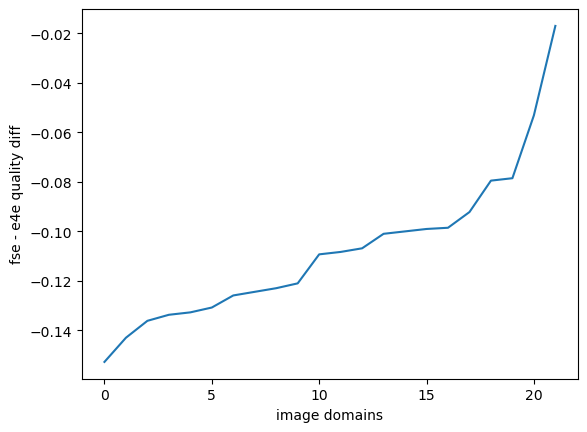

In [14]:
# IMAGE DOMAINS DIFFS

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.lineplot(
    df_quality_encoder_diff.loc[
        df_quality_encoder_diff['domain_type'] == 'image',
        'encoder_diff'
    ].tolist()
)
plt.xlabel('image domains')
plt.ylabel('fse - e4e quality diff')
plt.show()

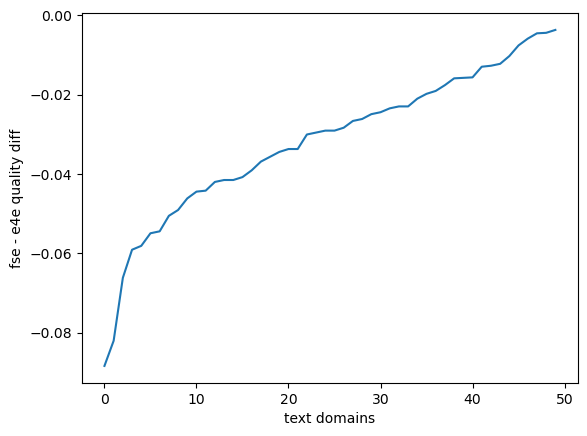

In [15]:
# IMAGE DOMAINS DIFFS

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.lineplot(
    df_quality_encoder_diff.loc[
        df_quality_encoder_diff['domain_type'] == 'text',
        'encoder_diff'
    ].tolist()
)
plt.xlabel('text domains')
plt.ylabel('fse - e4e quality diff')
plt.show()

In [19]:
# ALL DOMAINS:
# DIFFERENT DOMAINS: QUALITY DIFF OVER 0.10
# MID DOMAINS:       QUALITY DIFF BETWEEN [0.03, 0.10]
# SIMILAR DOMAINS:   QUALITY DIFF LESS THAN 0.03

# IMAGE DOMAINS:
# DIFFERENT DOMAINS: QUALITY DIFF OVER 0.12
# MID DOMAINS:       QUALITY DIFF BETWEEN [0.08, 0.12]
# SIMILAR DOMAINS:   QUALITY DIFF LESS THAN 0.08

# TEXT DOMAINS:
# DIFFERENT DOMAINS: QUALITY DIFF OVER 0.045
# MID DOMAINS:       QUALITY DIFF BETWEEN [0.025, 0.045]
# SIMILAR DOMAINS:   QUALITY DIFF LESS THAN 0.025

thresholds = {
    'all': [-0.03, -0.10],
    'image': [-0.08, -0.12],
    'text': [-0.025, -0.045]
}

In [17]:
# FOR ALL DOMAINS

diff_domains = df_quality_encoder_diff.loc[
    df_quality_encoder_diff['encoder_diff'] < thresholds['all'][1],
    's_domain'
].tolist()

mid_domains = df_quality_encoder_diff.loc[
    (df_quality_encoder_diff['encoder_diff'] > thresholds['all'][1]) & \
        (df_quality_encoder_diff['encoder_diff'] < thresholds['all'][0]),
    's_domain'
].tolist()

sim_domains = df_quality_encoder_diff.loc[
    df_quality_encoder_diff['encoder_diff'] > thresholds['all'][0],
    's_domain'
].tolist()

print("Different domains:", *diff_domains, '\n', sep='\n')
print("Mid domains:", *mid_domains, '\n', sep='\n')
print("Similar domains:", *sim_domains, '\n', sep='\n')

for filename, domains in zip(['diff', 'mid', 'sim'], [diff_domains, mid_domains, sim_domains]):
    with open(f'domain_encoder_metrics/{filename}_domains_list.txt', 'w') as f:
        for s_domain in domains:
            f.write(s_domain + '\n')

Different domains:
nigelwy_untitled_artwork_18 (image)
speed_paint (image)
titan_erwin (image)
wesley_gardner_portraitstudy (image)
stanislav_galai_04_23 (image)
mermaid (image)
rich_d_amaru_studyfinal (image)
jojo (image)
joker (image)
titan_armin (image)
remi_castaneda_sean_connery_final (image)
murasaki_nora_asuya (image)
oliver_wetter_corie_lynn_concept_1_final_back_web (image)
maria_trepalina_img_6833_1 (image)
rain_artwork_dtiyschallennge (image)


Mid domains:
truc_huynh_hex_009v2 (image)
disney_princess (image)
digital_painting_jing (image)
tolkien_elf (text)
botero (text)
ricardo_viana_render2 (image)
anastasia (image)
modigliani_painting (text)
hermione_granger_indomain (text)
hermione_granger (text)
dali_painting (text)
neanderthal (text)
naufal_ilyasa_seraphine_ig_full_res (image)
werewolf (text)
modigliani_painting_indomain (text)
ukiyo-e (text)
edvard_munch_painting (text)
tolkien_elf_indomain (text)
frida_kahlo_painting (text)
disney_princess (text)
anime (text)
the_than

In [20]:
# FOR IMAGE OR TEXT DOMAINS SEPARATELY

for domain_type in ['image', 'text']:
    df_tmp = df_quality_encoder_diff.loc[df_quality_encoder_diff['domain_type'] == domain_type]

    diff_domains = df_tmp.loc[
        df_tmp['encoder_diff'] < thresholds[domain_type][1], 's_domain'
    ].tolist()

    mid_domains = df_tmp.loc[
        (df_tmp['encoder_diff'] > thresholds[domain_type][1]) & (df_tmp['encoder_diff'] < thresholds[domain_type][0]),
        's_domain'
    ].tolist()

    sim_domains = df_tmp.loc[
        df_tmp['encoder_diff'] > thresholds[domain_type][0],
        's_domain'
    ].tolist()

    # print("Different domains:", *diff_domains, '\n', sep='\n')
    # print("Mid domains:", *mid_domains, '\n', sep='\n')
    # print("Similar domains:", *sim_domains, '\n', sep='\n')

    for filename, domains in zip(['diff', 'mid', 'sim'], [diff_domains, mid_domains, sim_domains]):
        with open(f'domain_encoder_metrics/{domain_type}_{filename}_domains_list.txt', 'w') as f:
            for s_domain in domains:
                f.write(s_domain + '\n')

In [57]:
df_encoder_diff_by_domain.loc[df_encoder_diff_by_domain['metric_name'] == 'diversity'].sort_values('encoder_diff')

,s_domain,metric_name,encoder_diff
110,sketch_indomain (text),diversity,0.024170
72,minimalist_drawing_indomain (text),diversity,0.037354
70,minimalist_drawing (text),diversity,0.039795
48,hulk_indomain (text),diversity,0.043457
52,impressionism_painting_indomain (text),diversity,0.045410
...,...,...,...
116,the_thanos (text),diversity,0.147156
130,ukiyo-e (text),diversity,0.152832
28,disney_princess (image),diversity,0.159424
30,disney_princess (text),diversity,0.159424


In [18]:
pd.get_dummies(df_metrics.loc[:, ['encoder_type']])

,encoder_type_e4e,encoder_type_fse,encoder_type_fse_with_features,encoder_type_fse_with_generator_shift,encoder_type_orig
0,False,False,False,False,True
1,False,False,False,False,True
2,False,False,False,False,True
3,False,False,False,False,True
4,True,False,False,False,False
...,...,...,...,...,...
935,False,True,False,False,False
936,False,False,True,False,False
937,False,False,True,False,False
938,False,False,False,True,False


In [ ]:
class EvaluationManager:
    def __init__(self, config, image_based=False):
        self.config = config
        self.device = config.training.device
        self.image_based = image_based
        
        for metric_name in config.evaluation.metrics:
            setattr(
                self, metric_name, metric_registry[metric_name](*args, **kwargs)
            )
        
        self.models = {
            visual_encoder: load_clip(visual_encoder, device=self.config.training.device)
            for visual_encoder in self.config.evaluation.vision_models
        }
        
    @torch.no_grad()
    def _encode_text(
        self, clip_model: nn.Module, text: str, templates: List[str] = ("A {}",)
    ):
        tokens = clip.tokenize(t.format(text) for t in templates).to(self.device)
        text_features = clip_model.encode_text(tokens).detach()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    @torch.no_grad()
    def _encode_target_image(
        self, clip_model: nn.Module, preprocess, target_image: str
    ):
        preprocessed = preprocess(Image.open(target_image)).unsqueeze(0).to(self.device)
        target_encoding = clip_model.encode_image(preprocessed)
        target_encoding /= target_encoding.clone().norm(dim=-1, keepdim=True)

        return target_encoding

    @torch.no_grad()
    def _encode_image(self, clip_model: nn.Module, preprocess, imgs: torch.Tensor):
        images = preprocess(imgs).to(self.device)
        image_features = clip_model.encode_image(images).detach()
        image_features /= image_features.clone().norm(dim=-1, keepdim=True)

        return image_features

    def _mean_cosine_sim(self, imgs_encoded: torch.Tensor, mean_vector: torch.Tensor):
        return (imgs_encoded.unsqueeze(1) * mean_vector).sum(dim=-1).mean().item()

    def _std_cosine_sim(self, imgs_encoded: torch.Tensor, mean_vector: torch.Tensor):
        return nn.CosineSimilarity()(imgs_encoded, mean_vector).std().item()

    def _diversity_from_embeddings_pairwise_cosines(self, imgs_encoded: torch.Tensor):
        data = (imgs_encoded @ imgs_encoded.T).cpu().numpy()
        mask = get_tril_elements_mask(data.shape[0])
        return np.mean(1 - data[mask])

    @torch.no_grad()
    def _generate_clip_data(
        self,
        clip_model,
        preprocess,
        source_generator,
        trainable,
        mapper_input=None,
    ):
        answer = []

        for idx in tqdm(range(self.config.evaluation.data_size // self.config.evaluation.batch_size)):

            sample_z = mixing_noise(
                self.config.evaluation.batch_size,
                512,
                self.config.training.mixing_noise,
                self.config.training.device
            )

            if self.config.training.patch_key == "original":
                imgs, _ = trainable(sample_z, input_is_latent=False)
            elif "mapper_config" in self.config.training:
                imgs, _ = source_generator(
                    sample_z,
                    offsets=trainable(mapper_input),
                    input_is_latent=False,
                )
            else:
                imgs, _ = source_generator(
                    sample_z, offsets=trainable(), input_is_latent=False
                )

            image_features = self._encode_image(clip_model, preprocess, imgs).detach()
            answer.append(image_features)

        return torch.cat(answer, dim=0)
    
    def get_images(self, generator):
        ...
        # returns images from trainable generator
    
    def calc_metrics(self, generator):
        
        for _ in range(1000 // batch_size):
            target_imgs = self.get_images(generator)
            
            for metric in self.metrics:
                metric.prepare(target_imgs)
                
            
            
        
        # Process metrics
        for metric in self.metrics:
            metric.calc() # Class.calc()
            
        return self.metrics
    
    def get_metrics(
        self,
        source_generator,
        trainable, 
        target,
        mapper_inputs=None,
    ):

        metrics = {}
        trainable.eval()
        source_generator.eval()

        if isinstance(target, str):
            target = [target]

        for key, (clip_model, preprocess) in self.models.items():
            for target_class in target:
                if mapper_inputs is not None:
                    mapper_input = mapper_inputs[target_class]
                else:
                    mapper_input = None
                
                domain_mean_vector = self._encode_text(clip_model, target_class).unsqueeze(0)
                imgs_encoded = self._generate_clip_data(
                    clip_model,
                    preprocess,
                    source_generator,
                    trainable,
                    mapper_input,
                )
                domain_mean_vector = self._encode_text(clip_model, target_class)
                cls_description = "_".join(target_class.lower().split())

                key_quality = f"quality/{cls_description}/{key.replace('/', '-')}"
                key_diversity = f"diversity/{cls_description}/{key.replace('/', '-')}"

                metrics[key_quality] = self._mean_cosine_sim(
                    imgs_encoded, domain_mean_vector
                )

                metrics[
                    key_diversity
                ] = self._diversity_from_embeddings_pairwise_cosines(imgs_encoded)

        return metrics
